# Load packages

In [1]:
# the code was writte with the following tf versions:
# pip install 'tensorflow==2.3.0' --force-reinstall
# pip install 'tensorflow-probability==0.11.0' --force-reinstall
import numpy as np
import pdb
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from matplotlib import patches as pat
tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
inv = np.linalg.inv
dot = np.linalg.multi_dot
clr = 'black'
import time
from cycler import cycler
import pickle
from scipy import ndimage

# Inference toy example, Figure 1

A toy example, showing the intuition of inference with a likelihood parametrized by a relu neural network

In [2]:
# Suppose we have a 1d latent variable z and a 1d observation x.
# We will uses the true prior p(z) = N(0,1) and a model to fit q(x|z)

class Model(tf.keras.Model):
    """ neural network that fits a decoder q(x|z)"""
    def __init__(self,nZ,nX,decoderActivation):
        super(Model, self).__init__()
        inputs = tf.keras.Input(shape=(nZ,))
        output_mean = tf.keras.layers.Dense(nX, activation = decoderActivation, use_bias=False)(inputs) # predicting mean
        
        homoscedasticNoise = True
        if homoscedasticNoise:   # homoscedastic,  q(x|z) = N(f(z),1)
            q_xgz = tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(t, tf.ones_like(t))) (output_mean)
        else:                 # heteroscedastic,   q(x|z) = N(f(z),g(z))
            v = tf.keras.layers.Dense(64,activation='relu')(inputs)
            v = tf.keras.layers.Dense(64,activation='relu') (v)
            v = tf.keras.layers.Dense(nX,activation = 'exponential')(v) # predicting inverse sd (diag)
            v = tf.keras.layers.ActivityRegularization(l2=1.)(v)
            merged =  tf.keras.layers.concatenate([m, v])
            q_xgz = tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(t[...,:nX], 1./t[...,nX:])) (merged)
        
        self.q_xgz = tf.keras.Model(inputs=inputs, outputs=q_xgz) 

    def __call__(self, z_, x_):
        q_xgz = self.q_xgz(z_)
        loss = - tf.reduce_mean(q_xgz.log_prob(x_))
        return loss

In [3]:
# define a grid over the spaces of the latent z and the observation x 

nPoints = 100
z_grid = tf.expand_dims(tf.linspace(-5.,5.,nPoints),1)
x_grid = tf.expand_dims(tf.linspace(-5.,5.,nPoints),1)
x_grid = tf.repeat(x_grid,nPoints,0) # repeat xgrid for each z
x_grid = tf.reshape(x_grid,[nPoints,nPoints,1]) # nX * nZ * 1
x_grid = tf.reverse(x_grid,[0]) # max in the first row, min in the last, for plotting
x_grid.shape

TensorShape([100, 100, 1])

In [4]:
# initialize the model and set the weights to 1

nZ = 1; nX = 1;
model = Model(nX = nX, nZ = nZ, decoderActivation = 'relu') 
out = model(tf.ones(shape=(128, nZ),dtype=tf.float32),tf.ones(shape=(128, nX),dtype=tf.float32)) # we pass the model fake data just to initialize the weights
model.q_xgz.layers[1].set_weights([np.ones((nZ,nX))]); # hand set the weight to ones

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0.,

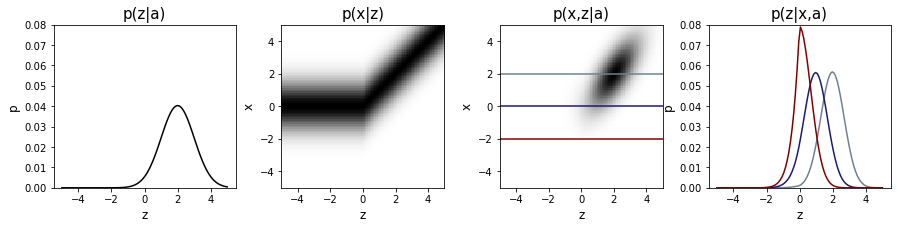

In [5]:
# plot the result, setting pz_mean to 2 or -2

pz_mean = 2

plt.figure(figsize=(15,3))
plt.subplot2grid((1, 4), (0, 0)); # 1st subplot - prior distribution p(z)
model.p_z = tfd.Normal(loc=pz_mean*tf.ones(nZ), scale=tf.ones(nZ)) # hard set for the figure
z_probs = model.p_z.prob(z_grid)
z_probs = z_probs/np.sum(z_probs) # renormalize within the range of the figure
plt.plot(z_grid,z_probs,'k')
plt.xticks(np.arange(min(z_grid)+1, max(z_grid), 2.0))
plt.xlabel('z',fontsize=12); plt.title('p(z|a)',fontsize=15); plt.ylabel('p',fontsize=12);
plt.ylim([0.,0.08])

plt.subplot2grid((1, 4), (0, 1)); # 2nd subplot - conditional distributions p(x|z)
p_xgz = model.q_xgz(z_grid) 
xgz_probs = np.squeeze(p_xgz.prob(x_grid))
xgz_probs = xgz_probs/np.mean(np.sum(xgz_probs,axis=0)) # divide by the mean to avoid right upper corner artifact
plt.imshow(xgz_probs,interpolation='none', extent=[-5,5,-5,5],cmap='gray_r');
plt.xlabel('z',fontsize=12); plt.title('p(x|z)',fontsize=15); plt.ylabel('x',fontsize=12)
x_mean = p_xgz.mean().numpy()

plt.subplot2grid((1, 4), (0, 2)) # 3rd subplot -  joint distributions p(x,z)
xz_probs = np.multiply(xgz_probs,z_probs.numpy().T) # p(x,z) = p(x|z)p(z) transpose z_probs to 1*nSamples so that mult is c-wise
plt.imshow(xz_probs,interpolation='none', extent=[-5,5,-5,5],cmap='gray_r');
plt.xlabel('z',fontsize=12);plt.title('p(x,z|a)',fontsize=15); plt.ylabel('x',fontsize=12);

testPoints = [30,50,70] # xs on which we will condition, from the top to bottom of y axis
colors = ['slategray','midnightblue','maroon']
step = (5 - -5)/nPoints
for tp in range(len(testPoints)):
    plt.axhline(y=5 - step*testPoints[tp],color=colors[tp]) # show the test points

plt.subplot2grid((1, 4), (0, 3)) # 4th subplot -  posterior distributions p(z|x)
for tp in range(len(testPoints)):
    zgx_prob = xz_probs[testPoints[tp],:]/np.sum(xz_probs[testPoints[tp],:]) # brute force posteriors
    plt.plot(z_grid,zgx_prob,color=colors[tp],label='_nolegend_') 
plt.xticks(np.arange(min(z_grid)+1, max(z_grid), 2.0))
plt.title('p(z|x,a)',fontsize=15);
plt.ylabel('p',fontsize=12); plt.xlabel('z',fontsize=12);
plt.ylim([0.,0.08]);
# plt.savefig('relu.pdf', format='pdf')

# Linear gaussian experiment, Figure 3

Here we will check different MI estimators on a toy example with a known MI between 2 variables z and x: both gaussian, correlated accross corresponsing dimensions.

$p(z) = \mathcal{N}(0,I_{d}); \ \ p(x) = \mathcal{N}(0,I_{d}); \ \ p(x|z) = \mathcal{N}(\rho z, (1-\rho)^{2}I_{d})$

This is convenient because we can compute marginal, joing entropies, as well as the true mutual information:

$H[p(z)] \propto \frac{d}{2}\log(\sigma_{z}^{2}); \ \ H[p(x)] \propto \frac{d}{2}\log(\sigma_{x}^{2})$

$H[p(x,z)] \propto \frac{d}{2}\log |\Sigma| = \frac{d}{2}\log(\sigma_{z}^{2}\sigma_{x}^{2} - \rho^{2}\sigma_{z}^{2}\sigma_{x}^{2}) = \frac{d}{2}\log((\sigma_{z}^{2}\sigma_{x}^{2})(1-\rho)^{2})$

And then we can get the true mutual information:

$I = \mathbb{E}_{x,z} \log \frac{p(x|z)}{p(x)} = H[p(x)] + H[p(z)] - H[p(x,z)] = -\frac{d}{2}\log(1-\rho^{2})$

In [6]:
# sample correlated z and x

# 2 functions below taken from https://github.com/google-research/google-research/blob/master/vbmi/vbmi_demo.ipynb
# On Variational Bounds of Mutual Information. ICML 2019
# Ben Poole, Sherjil Ozair, Aäron van den Oord, Alexander A. Alemi, George Tucker

# explanation: https://stats.stackexchange.com/questions/141427/how-does-the-formula-for-generating-correlated-random-variables-work
# derivation on Wikipedia: https://en.wikipedia.org/wiki/Mutual_information

def sample_correlated_gaussian(rho=0.5, dim=20, batch_size=128):
    """Generate samples from a correlated Gaussian distribution."""
    z, eps = tf.split(tf.random.normal((batch_size, 2 * dim)), 2, axis=1)
    x = rho * z + tf.sqrt(tf.cast(1. - rho**2, tf.float32)) * eps
    # x = x**3 # cubing for the nonlinear experiment
    return z, x

def rho_to_mi(dim, rho):
    return -0.5  * np.log(1-rho**2) * dim

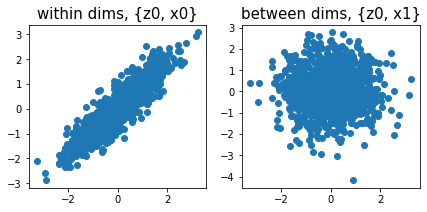

In [7]:
# show a batch of samples within and between dimensions

z, x = sample_correlated_gaussian(rho=0.9,batch_size=1000)
plt.figure(figsize=(7,3))
plt.subplot(1,2,1); plt.scatter(z[:,0],x[:,0]); plt.title('within dims, {z0, x0}',fontsize=15);
plt.subplot(1,2,2); plt.scatter(z[:,0],x[:,1]); plt.title('between dims, {z0, x1}',fontsize=15);

We will check 2 types of sampling estimators, one using the true p(x|z), and the other - a fitted q(x|z):

$I_{MCp} \approx \frac{1}{K}\sum_{i} \log \frac{p(x_{i}|z_{i})}{\frac{1}{K}\sum_{j}p(x_{i}|z_{j})} \ \ \ I_{MCq} \approx \frac{1}{K}\sum_{i} \log \frac{q(x_{i}|z_{i})}{\frac{1}{K}\sum_{j}q(x_{i}|z_{j})}$

In [164]:
# Sample based estimation of MI

def getMI_sampling(p_z, p_xgz, z_, x_):
    """MC estimator of MI; p_z and p_xgz are tensorflow probability distributions and z_, x_ are samples"""
    
    z_prob = p_z.prob(z_)
    H_z = - tf.reduce_mean(tf.math.log(z_prob))
    log_joint_ = p_z.log_prob(z_) + p_xgz.log_prob(x_)
    H_xz = -tf.reduce_mean(log_joint_,axis=-1) # across samples
    xgz_prob = p_xgz.prob(tf.expand_dims(x_,2)) # prob of every x(dim 1) given every z(dim 2)
    x_prob = tf.reduce_mean(xgz_prob,axis=2) # average across z
    H_x = - tf.reduce_mean(tf.math.log(x_prob)) # average across x
    MI = H_x + H_z - H_xz
    return H_x, H_z, H_xz, MI

Lower bound from Kolchinsky and Tracey '18. "Estimating Mixture Entropy with Pairwise Distances":

$I \geq I_{K} = - \frac{1}{K}\sum_{i} \log \frac{1}{K}\sum_{j} e^{-C_{\alpha}[p(x|z_{i})||p(x|z_{j})]} $, 

where $C_{\alpha}(p_{1}||p_{2}) = \frac{(1-\alpha)\alpha}{2} (\mu_{1}-\mu_{2})^{T} ((1-\alpha)\Sigma_{1} + \alpha \Sigma_{2})^{-1}(\mu_{1}-\mu_{2}) + \frac{1}{2}\log (\frac{|(1-\alpha)\Sigma_{1} + \alpha \Sigma_{2}|}{|\Sigma_{1}|^{(1-\alpha)}|\Sigma_{2}|^\alpha})$

In [165]:
# compute the MI bound based on Kolchinsky and Tracey '18

def getMI_Kolchinsky(p_xgz):
    """Nonparametric estimator of MI;
       p_xgz is tensorflow probability distribution with samples along 0th (batch) dimension"""
    
    means = tf.squeeze(p_xgz.mean())
    varis = tf.squeeze(p_xgz.variance())
    K = means.shape[0] #nSamples
    C = np.ones((K,K))*np.nan # matrix of divergences
    for k in range(K): 
        for j in range(K):
            C[k,j] = chernoff(means[k:k+1],varis[k:k+1],means[j:j+1],varis[j:j+1])
    I_k = - np.mean(np.log(np.mean(np.exp(-C),axis=-1)),axis=-1)
    return I_k

In [166]:
def chernoff(mean1, cov1, mean2, cov2):
    """Helper function for the nonparametric estimator above, computes chernoff alpha divergence,
       all inputs should have shape (batch_size,dimensions) i.e. (b,d)"""

    alpha = tf.constant(.5)
    x = (mean1 - mean2)         # (b,d)
    cov1 = tf.linalg.diag(cov1) # (b,d,d)
    cov2 = tf.linalg.diag(cov2) # (b,d,d)
    alphaCov = (1-alpha) * cov1 + alpha * cov2
    A = tf.linalg.inv(alphaCov) # (b,d,d)
    Ax =  tf.tensordot(A,x,[[2],[1]]) # (b,d,d) * (b,d) - > (b,d,1)
    diag = tf.linalg.diag_part(tf.transpose(Ax,[1,0,2])) # (d,b)
    xAx = tf.linalg.diag_part(tf.tensordot(x, diag, [[1],[0]])) # (b)
    term1 = (1.-alpha)*alpha / 2. * xAx    
    term2 = 0.5 * (tf.linalg.logdet(alphaCov) - (1.- alpha)*tf.linalg.logdet(cov1) - alpha*tf.linalg.logdet(cov2))
    C = tf.squeeze(term1) + term2
    return C

In [167]:
# Define a NN that fits q(x|z), and use the true prior p(z) = N(0,1)

class Model(tf.keras.Model):
    """ neural network that fits a decoder q(x|z)"""
    
    def __init__(self,nZ,nX):
        super(Model, self).__init__()

        inputs = tf.keras.Input(shape=(20,))
        inter = tf.keras.layers.Dense(64,activation='relu') (inputs)
        inter = tf.keras.layers.Dense(64,activation='relu') (inter)       
        m = tf.keras.layers.Dense(nX) (inter) # output mean
        homoscedasticNoise = False
        if homoscedasticNoise:   # homoscedastic
            q_xgz = tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(t, tf.ones_like(t))) (m)
        else:           # heteroscedastic
            v = tf.keras.layers.Dense(64,activation='relu')(inputs)
            v = tf.keras.layers.Dense(64,activation='relu') (v)
            v = tf.keras.layers.Dense(nX,activation = 'exponential')(v) # predicting inverse sd (diag)
            v = tf.keras.layers.ActivityRegularization(l2=1.)(v)
            merged =  tf.keras.layers.concatenate([m, v])
            q_xgz = tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(t[...,:nX], 1./t[...,nX:])) (merged)
    
        self.q_xgz = tf.keras.Model(inputs=inputs, outputs=q_xgz)  # N(f(z),1)

    def __call__(self, z_, x_):
        q_xgz = self.q_xgz(z_)
        loss = - tf.reduce_mean(q_xgz.log_prob(x_))
        return loss

# training routine for the q_xgz_model

def train_step(q_xgz_model,z_,x_):
    with tf.GradientTape() as tape:
        loss = q_xgz_model(z_,x_)
        loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss, q_xgz_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_xgz_model.trainable_variables))
    return loss

We will also test the Laplace approximation estimator:

$I_{L} = H[p(z)] - H[\hat{p}(z|x)];\ \ \hat{p}(z|x) = \mathcal{N}(0,[\nabla^{2} \log p(x,z)]^{-1})$


In [168]:
# Mutual information estimator based on Laplace approximation

def getMI_Laplace(q_xgz, z_mean, z_var,heteroscedastic=True):
    """Laplace approximation of the MI, needs q_xgz_model in the global workspace, 
       as well as params of p(z) as input - z_mean, z_var, both of shape batch*nZ
       q_xgz is tensorflow probability distribution, z_mean and z_var are parameters of p(z)"""
    
    nZ = z_mean.shape[-1]
    batch_size = z_mean.shape[0]
    with tf.GradientTape(watch_accessed_variables=False) as tape: # nabla_z [p(x,z)], evaluated at mu_z
        tape.watch(z_mean)
        q_xgz = q_xgz_model.q_xgz(z_mean) 
        x_mean = q_xgz.mean()
    jacobian = tape.batch_jacobian(x_mean, z_mean, experimental_use_pfor=True); # nB x nX x nZ
    x_cvar = q_xgz.variance() # diagonal
    x_precision_rep = tf.repeat(tf.expand_dims(1./x_cvar,-1),repeats =  nZ,axis=-1); # nB x nX x nZ
    if heteroscedastic:
        likelihood_term = tf.matmul(tf.transpose(tf.multiply(jacobian,x_precision_rep),(0,2,1)),jacobian); # nB x nZ x nZ
    else:
        likelihood_term = tf.matmul(tf.transpose(jacobian,(0,2,1)),jacobian); # nB x nZ x nZ
    z_precision = tf.linalg.diag(1./z_var)
    const = nZ/2. * (np.log(2.*np.pi*np.e))
    
    entPrior = - 0.5*tf.linalg.logdet(z_precision) + const 
    entLike = - 0.5*tf.linalg.logdet(likelihood_term + 0.1*tf.linalg.diag(tf.ones((batch_size,nZ)))) + const #eye for stability
    entPost = - 0.5*tf.linalg.logdet(z_precision + likelihood_term + 0.01*tf.linalg.diag(tf.ones((batch_size,nZ))))  + const
    INFOgain = entPrior - entPost
    return entPrior, entLike, entPost, INFOgain

In [ ]:
# evaluate different MI estimator for a range of correlations (i.e. mutual informations)

rhoList = [0.5,0.7,.9,.99,.999] # correlations to test
nZ  = 20; nX = nZ
nB = 1
nSamples = 1000

allMI, allHz, allHx, allHxz, allHxgz  = [np.nan*np.zeros((len(rhoList),5)) for i in range(5)]# ground truth, MC joint, NN joint

for condition in range(len(rhoList)):
    print('Running condition ' + str(condition))
    rho = rhoList[condition]

    ## ground truth measures
    p_z = tfd.MultivariateNormalDiag(tf.zeros(nZ), tf.ones(nZ)) # N(0,1), the true p(z)
    MI = rho_to_mi(nZ, rho)
    Hz = np.squeeze(p_z.entropy()); Hx = Hz;
    Hxz = Hx + Hz - MI
    allMI[condition,0] = MI; allHz[condition,0] = Hz; 
    allHx[condition,0] = Hx; allHxz[condition,0] = Hxz
    
    # sample datapoints from the true joint
    z_,x_ = sample_correlated_gaussian(rho=rho, dim=nZ, batch_size=nSamples) 
    z_ = tf.expand_dims(z_,axis=0) # add batch dimension to keep the code portable
    x_ = tf.expand_dims(x_,axis=0) # add batch dimension to keep the code portable

    ## MI estimate based on knowledge of the ground-truth joint
    p_z = tfd.MultivariateNormalDiag(tf.zeros((nB,nZ)), tf.ones((nB,nZ)))
    p_xgz = tfd.MultivariateNormalDiag(rho*z_,tf.cast(tf.sqrt(1.-rho**2), tf.float32)*tf.ones(x_.shape))
    Hx, Hz, Hxz, MI = getMI_sampling(p_z, p_xgz, z_, x_)
    allMI[condition,1] = MI; allHz[condition,1] = Hz; 
    allHx[condition,1] = Hx; allHxz[condition,1] = Hxz
    allHxgz[condition,0] = np.mean(p_xgz.entropy()) # the true p(x|z) entropy
    allHxgz[condition,1] = np.mean(p_xgz.entropy()) # the one from samples - they are the same as H[x|z] doesn't depend on z

    ## MI estimate based on fitting a model q(x|z)
    q_xgz_model = Model(nZ, nX)  # fit a neural network to estimate p(x|z)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    allLosses = []
    for iter in range(10000): # 10000
        z_train,x_train = sample_correlated_gaussian(rho=rho, dim=nZ, batch_size=nSamples) 
        loss = train_step(q_xgz_model,z_train,x_train)
        allLosses.append(loss)

    q_xgz = q_xgz_model.q_xgz(z_)
   
    Hx, Hz, Hxz, MI = getMI_sampling(p_z, q_xgz, z_, x_)
    allMI[condition,2] = MI; allHz[condition,2] = Hz; 
    allHx[condition,2] = Hx; allHxz[condition,2] = Hxz
    allHxgz[condition,2] = np.mean(q_xgz.entropy())

    ## get the measures based on Kolchinsky and Tracey bound
    allMI[condition,3] = getMI_Kolchinsky(p_xgz)

    ## get the measures based on the Laplace approximation
    entPrior, entLike, entPost, INFOgain = getMI_Laplace(q_xgz, p_z.mean(), p_z.variance(), heteroscedastic=True)
    allMI[condition,4] = INFOgain;

Running condition 0
passed
Running condition 1


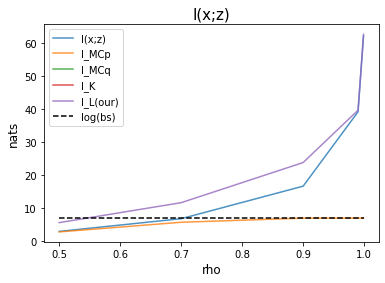

In [18]:
plt.plot(rhoList,allMI,alpha=0.8); plt.title('I(x;z)',fontsize=15); plt.xlabel('rho',fontsize=12); plt.ylabel('nats',fontsize=12);
plt.plot(rhoList,[np.log(nSamples)]*len(rhoList),'k--'); plt.legend(['I(x;z)','I_MCp','I_MCq','I_K','I_L(our)','log(bs)'])
# plt.savefig('linear.pdf', format='pdf')
# files.download("linear.pdf") 

# MNIST active sensing experiment

In [2]:
# load MNIST dataset
# https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb#scrollTo=JSQyXgzxzZPv

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
mnist = fetch_openml('mnist_784', cache=False, as_frame = False)
X = mnist.data.astype('float32')
X = (X - np.mean(X))/np.std(X)
y = mnist.target.astype('int64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

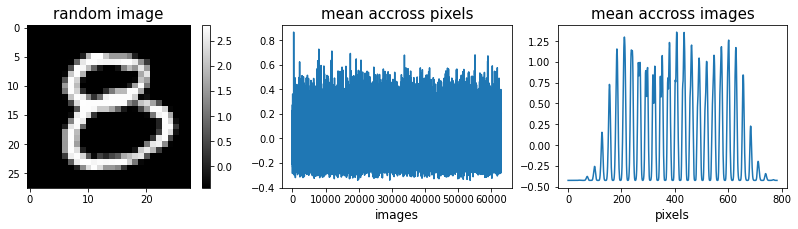

In [3]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1); plt.title('random image',fontsize=15)
plt.imshow(np.reshape(X_train[0],(28,28)),cmap=plt.get_cmap('gray'), interpolation='none'); plt.colorbar();
plt.subplot(1,3,2); plt.title('mean accross pixels',fontsize=15); plt.xlabel('images',fontsize=12)
plt.plot(np.mean(X_train,axis=1));
plt.subplot(1,3,3); plt.title('mean accross images',fontsize=15); plt.xlabel('pixels',fontsize=12)
plt.plot(np.mean(X_train,axis=0));

In [4]:
# input handling

def get_patches(args):
    """extracts patches from images"""
    
    images_shaped = args[0] # of size 28 * 28
    indeces = args[1] # patch center
    wi = args[2] # patch half-width
    return images_shaped[indeces[0]-wi:indeces[0]+wi,indeces[1]-wi:indeces[1]+wi]

def MNIST_to_RNN(images, nTimesteps = 5, wi = 2, im_size = 28):
    """converts images to RNN's input, images have shape batch * xy, wi is patch half-width
       for every timestpe returns concatenated images, indeces, patches"""
    
    images_shaped = tf.reshape(images,(-1,im_size,im_size)) # batch * x * y
    batch_size = images.shape[0]
    wi_map = tf.cast(tf.ones(batch_size,1)*wi,tf.int32) # repeat same patch half-width for every image
    for tt in range(nTimesteps):
        indeces = tf.random.uniform((batch_size,2), minval = wi, maxval=im_size-wi,dtype=tf.int32) # random patch centers
        patches_shaped = tf.map_fn(get_patches,(images_shaped,indeces,wi_map), dtype= (tf.float32)) # extract patch from every image
        patches = tf.reshape(patches_shaped,(-1,wi*2*wi*2)) # flatten patches
        
        # add noise to patch centers to aid patch optimization later
        indeces = tf.cast(indeces,tf.float32) +  tf.random.normal((batch_size,2),stddev=0.1) 
        if tt ==0:
            allData = tf.cast(tf.concat([images,indeces,patches],axis=1),tf.float32)
            allData = tf.expand_dims(allData,axis=1) # timesteps
        else:
            temp = tf.expand_dims(tf.cast(tf.concat([images,indeces,patches],axis=1),tf.float32),axis=1)
            allData = tf.concat([allData,temp],axis=1)
    return allData
    
def get_MNIST_datatset(X_train,batch_size):
    """creates a tensorflow dataset"""
    
    dataset = tf.data.Dataset.from_tensor_slices((X_train))
    dataset = dataset.shuffle(buffer_size=1000) # across images
    dataset_batched = dataset.batch(batch_size, drop_remainder = True)
    dataset_batched = dataset_batched.map(MNIST_to_RNN) # extract patches for every timestep
    return dataset_batched

In [5]:
# test dataset generation routine

batch_size = 64
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
dataset_batched = get_MNIST_datatset(X_train,batch_size) # makes new random patches every call
print(dataset_batched.take(1)) # bath_size * nTimesteps * im_size*im_size+indeces_size+patch_size

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Use fn_output_signature instead
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team

In [6]:
# define the variational RNN model First, make a 'cell' - a class for what happens at every timestep, 
# then - wrap it in the model that processes the whole sequence for simplicity and efficiency

class Timestep(tf.keras.layers.Layer):
    """custom RNN cell - defines computations that happens at every timestep"""
    
    def __init__(self,num_hidden,input_dim,state_dim,homoscedastic,**kwargs):
            
        self.wi = 2 # patch half-width
        self.nh = num_hidden # dim of the RNN hidden state
        self.nx = input_dim # dim of input
        self.nz = state_dim  # dim of the latent variable
        self.n_phi = 128 # number of hidden neurons in intermediate layers
        self.lstm =  tf.keras.layers.GRUCell(self.nh) # RNN, swictched to GRU from LSTM

        # define the layers (weights will be initialized upon the first call)
        # intermediate layers
        self.phi_p_mean = tf.keras.Sequential(self.get_phi_layers(self.n_phi))# for mean of p(z)
        self.phi_p_var = tf.keras.Sequential(self.get_phi_layers(self.n_phi)) # for var of p(z)
        self.phi_e = tf.keras.Sequential(self.get_phi_layers(self.n_phi)) # for encoder
        self.phi_x = tf.keras.Sequential(self.get_phi_layers(self.n_phi)) # for input x
        self.phi_a = tf.keras.Sequential(self.get_phi_layers(self.n_phi)) # for action
        
        # prior
        self.pz_mean = tf.keras.layers.Dense(self.nz)
        self.pz_var = tf.keras.layers.Dense(self.nz)
        
        # encoder
        self.qz = tf.keras.layers.Dense(self.nz*2) # mean plus variance
        
        # decoder, image head, always homoscedastic
        MLP = True
        if MLP:  # dense decoder (multilayer perceptron)
            inputs = tf.keras.Input(shape=(self.nz,))
            inter = tf.keras.layers.Dense(self.n_phi, activation='softplus')(inputs) # this layer is common for image and patch decoders
            m = tf.keras.layers.Dense(self.n_phi, activation='softplus')(inter)
            m = tf.keras.layers.Dense(self.nx)(m) # predicting mean, image
            p_xgz_image = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale = tf.ones_like(t))) (m)
            
        else: # convolutional decoder
            nFilters = 4
            # self.bottleneckShape = (7,7,nFilters) # for CIFAR
            self.bottleneckShape = (4,4,nFilters) # for MNIST
            inputs = tf.keras.Input(shape=(self.nz,))
            inter = tf.keras.layers.Dense(self.bottleneckShape[0] *  self.bottleneckShape[1] *  self.bottleneckShape[2])(inputs)
            d = tf.keras.layers.Reshape(self.bottleneckShape) (inter)
            d = tf.keras.layers.Conv2DTranspose(filters=nFilters, kernel_size=2, strides=2, activation='softplus', padding='same') (d)
            d = tf.keras.layers.Conv2DTranspose(filters=nFilters//2, kernel_size=2, strides=2, activation='softplus', padding='same') (d)
            # d = tf.keras.layers.Conv2DTranspose(filters=nFilters//4, kernel_size=2, strides=2, activation='softplus', padding='same') (d) # for CIFAR
            d = tf.keras.layers.Conv2DTranspose(filters=nFilters//4, kernel_size=2, activation='softplus', padding='same') (d)   # for MNIST
            m = tf.keras.layers.Conv2DTranspose(1, 1, activation='linear', padding='same') (d) # check if the activation fits
            m = tf.keras.layers.Reshape((self.nx,))(m)
            p_xgz_image = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale = tf.ones_like(t))) (m)

        # decoder, patch head:
        nP = self.wi*2*self.wi*2 # wi is half-width
        pat = tf.keras.layers.Dense(self.n_phi, activation='softplus')(inter)
        pat = tf.keras.layers.Dense(nP)(pat)

        if homoscedastic:
            p_xgz_patch = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale = tf.ones_like(t))) (pat)
        else: 
            v = tf.keras.layers.Dense(nP,activation = 'relu')(inter) # predicting inverse sd (diag)
            # v = tf.keras.layers.ActivityRegularization(l2=1.)(v)
            merged =  tf.keras.layers.concatenate([pat, v])
            p_xgz_patch = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc = t[...,:nP], scale = t[...,nP:] + 1.)) (merged)

        self.decoder_image = tf.keras.Model(inputs=inputs, outputs=p_xgz_image)
        self.decoder_patch = tf.keras.Model(inputs=inputs, outputs=p_xgz_patch)

        self.state_size = [self.nh] # needed later for the outer RNN
        self.output_size = self.nh  # needed later for the outer RNN
        super(Timestep, self).__init__(**kwargs)
    
    def get_phi_layers(self,units): # intermediate layers
        return [tf.keras.layers.Dense(units=units,activation='softplus'),
                tf.keras.layers.Dense(units=units,activation='softplus')]
    
    def step(self, data, RNNstate, training = False):
        # define the information flow at every time step

        h = RNNstate[0] # get the RNN state h (LSTM has 2 states, GRU has 1)
        images = data[:,:self.nx] 
        indices = data[:,self.nx:self.nx+2] # actions are indices of patches centers within images, 2d here
        patches = data[:,self.nx+2:]
        
        ### PRIOR ###
        mean_p, var_p = self.get_p(indices,RNNstate) # p(z|a,h)
        p_z = tfd.Normal(mean_p,var_p)

        ### ENCODER ###
        a_ = self.phi_a(indices) # transformed action
        x_ = self.phi_x(patches) # transformed observation (patch)
        z_hidden = self.qz(self.phi_e(tf.concat((x_,a_,h),axis=1))) # observation + prev.action + prev.state
        mean_q, logvar_q = tf.split(z_hidden, num_or_size_splits=2, axis=1) 
        var_q = tf.exp(logvar_q)
        q_z = tfd.Normal(mean_q,var_q)
        z = q_z.sample()

        ### DECODER ###
        p_xgz_image = self.decoder_image(z)
        p_xgz_patch = self.decoder_patch(z)

        ### LOSSES ###
        loss_image =  tf.reduce_sum( - p_xgz_image.log_prob(images) ,axis=1)  # sum across dimensions
        loss_patch =  tf.reduce_sum( - p_xgz_patch.log_prob(patches) ,axis=1) # sum across dimensions    
        kl_loss = tf.reduce_sum( tfp.distributions.kl_divergence(q_z,p_z) ,axis=1) # KL(q(z)||p(z)),sum across dimensions of z  
        loss = loss_image + loss_patch + kl_loss

        ### RNN update ###
        output, newstate = self.lstm(tf.concat((z,a_),axis=1), RNNstate) # without observations

        ### return ###
        if training:                # training mode
            return loss, newstate
        else:                       # inspection mode
            return loss, newstate, p_z.mean().numpy(), p_z.variance().numpy(), q_z.mean().numpy(),\
                q_z.variance().numpy(), p_xgz_image.mean().numpy(), p_xgz_image.variance().numpy(),\
                p_xgz_patch.mean().numpy(), p_xgz_patch.variance().numpy()
         
    def get_p(self,indices,state):
        h = state[0]
        a_ = self.phi_a(indices) # transformed action
        mean_p  = self.pz_mean(self.phi_p_mean(tf.concat((a_,h),axis=1))) # given action and RNN state
        logvar_p = self.pz_var(self.phi_p_var(tf.concat((a_,h),axis=1))) 
        var_p = tf.exp(logvar_p)
        return mean_p, var_p
    
    def __call__(self, data, RNNstate):
        # the main cell interface
        loss, newstate = self.step(data, RNNstate, training = True)
        return loss, newstate

class VRNN(tf.keras.Model):
    """wrapper for the full RNN model"""
    
    def __init__(self,num_hidden,batch_size,input_dim,state_dim,homoscedastic):
        # initialize the RNN, and define a small net for learning h0
        super(VRNN, self).__init__()
        self.cell = Timestep(num_hidden,input_dim,state_dim,homoscedastic)
        self.RNN =  tf.keras.layers.RNN(cell = self.cell, return_sequences = True)
        self.NN_h0 = tf.keras.layers.Dense(units=num_hidden)

    def get_h0(self,batch_size):
        # get the initial RNN state
        init_state_h = self.NN_h0(tf.ones((batch_size,1)))
        init_state = [init_state_h]
        return init_state

    def __call__(self, data, training = True):
        batch_size = data.shape[0]
        initial_state = self.get_h0(batch_size) # predict h_0 from the first observation
        loss = self.RNN(inputs = data, initial_state = initial_state)  #
        return loss

In [7]:
# get an optimized training function for a specific model
# https://github.com/tensorflow/tensorflow/issues/27120

def get_training_function():
    @tf.function
    def train_step(batch,model,optimizer):
        print("tracing")
        with tf.GradientTape() as tape:
            loss = model(batch)
            loss = tf.reduce_mean(loss) # across timesteps and batch
        grads = tape.gradient(loss, model.trainable_variables)
        grads_clipped, _ = tf.clip_by_global_norm(grads, 10.)
        optimizer.apply_gradients(zip(grads_clipped, model.trainable_variables))
        return loss
    return train_step

In [8]:
# simulate a noisyTV

def add_noise(images, noiseWidth = 10, noiseWeight = 10.):
    """add [0,1]*noiseWeight noise of width noiseWidth pixels"""
    
    noise = np.random.rand(images.shape[0],noiseWidth*noiseWidth)*noiseWeight
    ind = np.array([]) # get indeces of where to add noise, always left upper corner
    for ii in range(noiseWidth):
        ind = np.concatenate((ind,(np.arange(ii*28,ii*28+noiseWidth))))
    ind = ind.astype(np.int32)
    allInd = [(gg,ii) for ii in ind for gg in range(images.shape[0])]
    rows, cols = zip(*allInd)
    images[rows,cols] = images[rows,cols] + noise.ravel()
    return images
# images = add_noise(images)
# plt.imshow(np.reshape(images[8],(28,28)))

0.9711428571428572
0.9577142857142857


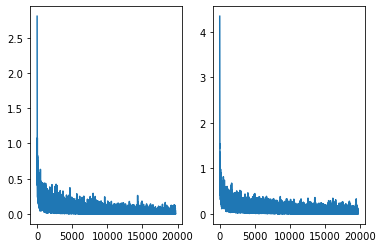

In [9]:
# a classifier trained with and without the noisyTV, used for active sensing evaluation later

class ClassifierMNIST(tf.keras.Model):
    """a simple MNIST classifier"""
    
    def __init__(self):
        super(ClassifierMNIST, self).__init__()
        inputs = tf.keras.Input(shape=(28*28,))
        inter = tf.keras.layers.Dense(64,activation='relu') (inputs)
        inter = tf.keras.layers.Dense(64,activation='relu') (inputs)
        inter = tf.keras.layers.Dense(10) (inter)
        p_ygx = tfp.layers.DistributionLambda(lambda t: tfd.Categorical(logits = t)) (inter)
        self.p_ygx = tf.keras.Model(inputs=inputs, outputs=p_ygx)

    def __call__(self, x_, y_):
        p_ygx = self.p_ygx(x_)
        loss = - tf.reduce_mean(p_ygx.log_prob(y_))
        return loss
    def predict(self,x_):
        p_ygx = self.p_ygx(x_)
        return p_ygx.mean()
    
def train_step_classifier(p_ygx_model,x_,y_):
    with tf.GradientTape() as tape:
        loss = p_ygx_model(x_,y_)
        loss = tf.reduce_mean(loss) # accross timesteps and batch
    grads = tape.gradient(loss, p_ygx_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, p_ygx_model.trainable_variables))
    return loss

all_p_ygx_models = []
for condition in range(2):
    addNoisyTV = bool(condition)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    if addNoisyTV:
        X_train = add_noise(X_train)
        X_test = add_noise(X_test)
        
    # Prepare the training dataset.
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
    # initialize and train the classifier
    p_ygx_model = ClassifierMNIST()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    allLosses = []
    for epoch in range(20):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss = train_step_classifier(p_ygx_model,x_batch_train,y_batch_train)
            allLosses.append(loss)
            
    plt.subplot(1,2,condition+1); plt.plot(allLosses);
    p_ygx = p_ygx_model.p_ygx(X_test)
    y_pred = p_ygx.mode().numpy()
    match = y_pred==y_test
    match = match.astype(np.int32)
    acc = np.sum(match)/match.shape[0]
    print(acc)
    all_p_ygx_models.append(p_ygx_model)

In [10]:
# get an optimized function that computes expected infogain
# https://github.com/tensorflow/tensorflow/issues/27120

def get_patch_optimizer():
    @tf.function
    def _getMI_Laplace(z_mean,z_var,model):
        
        print("tracing")
        batch_size = z_mean.shape[0]
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(z_mean)
            p_xgz_patch = model.cell.decoder_patch(z_mean) 
            mu = p_xgz_patch.mean()
        jacobian = tape.batch_jacobian(mu, z_mean, experimental_use_pfor=True); # nB x nX x nZ
        x_cvar = p_xgz_patch.variance() # diagonal
        x_precision_rep = tf.repeat(tf.expand_dims(1./x_cvar,-1),repeats =  model.cell.nz,axis=-1); # nB x nX x nZ
        likelihood_term = tf.matmul(tf.transpose(tf.multiply(jacobian,x_precision_rep),(0,2,1)),jacobian); # nB x nZ x nZ
        z_precision = tf.linalg.diag(1./z_var)
        
        entPrior = - tf.linalg.logdet(z_precision + 0.5*tf.linalg.diag(tf.ones((batch_size,model.cell.nz)))); 
        entLike = - tf.linalg.logdet(likelihood_term + 0.5*tf.linalg.diag(tf.ones((batch_size,model.cell.nz)))) #eye for stability
        entPost = - tf.linalg.logdet(z_precision + likelihood_term + 0.5*tf.linalg.diag(tf.ones((batch_size,model.cell.nz))))
        INFOgain = entPrior - entPost
        return entPrior, entLike, entPost, INFOgain
    return _getMI_Laplace

In [11]:
# Optimize info-theoretic measure wrt patch location for a single timestep

def optimize_info_step(getMI_Laplace, model, allIndices, tt, state, optimizer_action, batch_size, measure_flag='I(z;x)'):
    
    nIter = tf.constant(100,dtype = tf.int32)
    for iter in tf.range(nIter):
        # get grad dIG/da, where a is patch location parametrized by indeces of patch center
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(allIndices)
            indeces = tf.squeeze(tf.slice(allIndices,[0,tt,0],[batch_size,1,2]))
            z_mean, z_var = model.cell.get_p(indeces,state)    
            entPrior, entLike, entPost, INFOgain = getMI_Laplace(z_mean,z_var,model) 
            if measure_flag == 'I(z;x)':
                loss_t = tf.reduce_mean(-INFOgain)
            elif measure_flag == 'H(z)':
                loss_t = tf.reduce_mean(-entPrior)
            elif measure_flag == 'H(z|x)':
                loss_t = tf.reduce_mean(entPost)
        # apply grad 
        grad = tape.gradient(loss_t,allIndices)
        optimizer_action.apply_gradients(zip([grad],[allIndices]))

        # logs and gradient checks
        if tf.math.equal(iter,tf.constant(0,dtype=tf.int32)):
            all_IG_t = tf.expand_dims(INFOgain,0); 
            all_Hprior_t = tf.expand_dims(entPrior,0); 
            all_Hpost_t  = tf.expand_dims(entPost,0)
        else:
            all_IG_t = tf.concat((all_IG_t, tf.expand_dims(INFOgain,0)),axis=0)
            all_Hprior_t = tf.concat((all_Hprior_t, tf.expand_dims(entPrior,0)),axis=0)
            all_Hpost_t = tf.concat((all_Hpost_t, tf.expand_dims(entPost,0)),axis=0)
        
        if tt==0 and iter==0: # assert that the grad wrt gg is not 0
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(allIndices)
                indeces = tf.squeeze(tf.slice(allIndices,[0,tt,0],[batch_size,1,2]))
                mean_p_i, var_p_i = model.cell.get_p(indeces,state)    
                entPrior, entLike, entPost, INFOgain = getMI_Laplace(mean_p_i,var_p_i,model) 
                loss_t = tf.reduce_mean(-entLike)
            grad = tape.gradient(loss_t,allIndices)
            assert tf.reduce_sum(grad) != 0

    return allIndices, all_IG_t, all_Hprior_t, all_Hpost_t

In [12]:
# A wrapper that optimizes info-theoretic measure wrt patch location for all timesteps

def optimize_info(getMI_Laplace, images, labels, model, p_ygx_model, wi, nTimesteps = 5, measure_flag='I(z;x)'):
    
    allNLL = np.zeros(nTimesteps)
    optimizer_action = tf.keras.optimizers.Adam(learning_rate=.1)
    batch_size = images.shape[0]
    im_size = int(np.sqrt(images.shape[1]))
    images_shaped = tf.reshape(images,(-1,im_size,im_size))
    
    # sample random indeces first for all timesteps
    allIndices_rand = tf.random.uniform((batch_size,nTimesteps,2), minval = wi, maxval=im_size-wi, dtype=tf.float32) # random
    allIndices = tf.random.uniform((batch_size,nTimesteps,2), minval = wi, maxval=im_size-wi, dtype=tf.float32)
    allIndices = tf.Variable(allIndices) # Variable can be optimized

    # initialize the RNN state at t0
    state = model.get_h0(batch_size) # predict h_0
    for tt in range(nTimesteps):
        allIndices, all_IG_t, all_Hprior_t, all_Hpost_t = optimize_info_step(getMI_Laplace, model, allIndices, tt, state, optimizer_action, batch_size, measure_flag = measure_flag)
        
        if tt==0:
            all_IG = tf.expand_dims(all_IG_t,0)
            all_Hprior = tf.expand_dims(all_Hprior_t,0)
            all_Hpost = tf.expand_dims(all_Hpost_t,0)
        else:
            all_IG = tf.concat((all_IG,tf.expand_dims(all_IG_t,0)),axis=0)
            all_Hprior = tf.concat((all_Hprior,tf.expand_dims(all_Hprior_t,0)),axis=0)
            all_Hpost = tf.concat((all_Hpost,tf.expand_dims(all_Hpost_t,0)),axis=0)

        # generative process, get the patches of optimized indeces
        # testing the hypothesis of the effect of the first step
        testingZeroStepEffect = False
        if testingZeroStepEffect and tt==0:
            indeces_R = tf.cast(tf.round(allIndices_rand[:,tt,:]),tf.int32)
        else:
            indeces_R = tf.cast(tf.round(allIndices[:,tt,:]),tf.int32)
            
        indeces_R = tf.clip_by_value(indeces_R, wi, im_size-wi)
        wi_map = tf.cast(tf.ones(batch_size,1)*wi,tf.int32)
        patches_shaped = tf.map_fn(get_patches,(images_shaped,indeces_R,wi_map), dtype= (tf.float32))
        patches = tf.reshape(patches_shaped,(-1,wi*2*wi*2))
        
        # update the RNN state
        if testingZeroStepEffect and tt==0:
            indeces = tf.squeeze(tf.slice(allIndices_rand,[0,tt,0],[batch_size,1,2]))
        else:
            indeces = tf.squeeze(tf.slice(allIndices,[0,tt,0],[batch_size,1,2]))
            
        data = tf.concat([images,indeces,patches],axis=1)
        loss, state, mean_p, var_p, mean_q, var_q, mean_xgz, var_xgz, mean_pat, var_pat = model.cell.step(data,state,training=False)
        
        # get reconstruction error
        p_xgz_image = model.cell.decoder_image(mean_q) 
        nll =  - p_xgz_image.log_prob(images)
        
        # get classification performance
        p_ygx = p_ygx_model.p_ygx(p_xgz_image.mean())
        y_pred = p_ygx.mode().numpy()
        match = y_pred==labels
        match = match.astype(np.int32)
        acc = np.sum(match)/match.shape[0]
        
        if tt==0:
            allNLL = tf.expand_dims(nll,0)
            allAcc = tf.expand_dims(acc,0)
        else:
            allNLL = tf.concat((allNLL,tf.expand_dims(nll,0)),axis=0)
            allAcc = tf.concat((allAcc,tf.expand_dims(acc,0)),axis=0)
    
    return all_IG, all_Hprior, all_Hpost, allNLL, allIndices, allAcc

In [13]:
# pick a random patch locations at every timestep, used as baseline for comparison

def random_info(images, labels, model, p_ygx_model, wi, nTimesteps = 5, measure_flag='I(z;x)'):
    
    batch_size = images.shape[0]
    images_shaped = tf.reshape(images,(-1,28,28))
    state = model.get_h0(batch_size) # predict h_0 
    # sample random patch indices
    allIndices_rand = tf.random.uniform((batch_size,nTimesteps,2), minval = wi, maxval=28-wi, dtype=tf.float32) # random
   
    for tt in range(nTimesteps):
        
        # generative process, get the patches
        indeces_R = tf.cast(tf.round(allIndices_rand[:,tt,:]),tf.int32)
        indeces_R = tf.clip_by_value(indeces_R, wi, 28-wi)
        wi_map = tf.cast(tf.ones(batch_size,1)*wi,tf.int32)
        patches_shaped = tf.map_fn(get_patches,(images_shaped,indeces_R,wi_map), dtype= (tf.float32))
        patches = tf.reshape(patches_shaped,(-1,wi*2*wi*2))
        
        # update the RNN state
        indeces = allIndices_rand[:,tt,:]
        data = tf.concat([images,indeces,patches],axis=1)
        loss, state, mean_p, var_p, mean_q, var_q, mean_xgz, var_xgz, mean_pat, var_pat = model.cell.step(data,state,training=False)
        
        # get reconstruction error
        p_xgz_image = model.cell.decoder_image(mean_q) 
        logprob = p_xgz_image.log_prob(images)
        nll = - tf.reduce_sum(logprob,axis=1)
        
        # get classifier accuracy
        p_ygx = p_ygx_model.p_ygx(p_xgz_image.mean())
        y_pred = p_ygx.mode().numpy()
        match = y_pred==labels
        match = match.astype(np.int32)
        acc = np.sum(match)/match.shape[0]

        if tt == 0:
            nll_ii = tf.expand_dims(nll,0)
            acc_ii = tf.expand_dims(acc,0)
        else:
            nll_ii = tf.concat((nll_ii,tf.expand_dims(nll,0)),axis=0)
            acc_ii = tf.concat((acc_ii,tf.expand_dims(acc,0)),axis=0)
        
    return nll_ii, acc_ii

In [14]:
# brute force calculated best patch location (in terms of NLL of image reconstruction)

def best_info(images, labels, model, p_ygx_model, wi, nTimesteps = 5):
    im_size = 28
    pcList = [] # list all possible patch locations
    for yy in range(im_size//wi-1):
        for xx in range(im_size//wi-1):
            pcList.append([wi*(yy+1),wi*(xx+1)])
    indeces_R = tf.constant(pcList)
    b_size = len(pcList)
    wi_map = tf.cast(tf.ones(b_size,1)*wi,tf.int32)

    for im in range(images.shape[0]):

        state = model.get_h0(b_size) # predict h_0 from the first observation
        testImages = tf.tile(images[im:im+1],[b_size,1]) # repeat the same test image
        testImages_shaped = tf.reshape(testImages,[b_size,im_size,im_size]) # for every patch location
        testPatches_shaped = tf.map_fn(get_patches,(testImages_shaped,indeces_R,wi_map), dtype= (tf.float32))
        testPatches = tf.reshape(testPatches_shaped,(-1,wi*2*wi*2))
        testIndeces = tf.cast(indeces_R,tf.float32)
        data = tf.concat([testImages,testIndeces,testPatches],axis=1)

        for tt in range(nTimesteps):

            loss, state, mean_p, var_p, mean_q, var_q, mean_xgz, var_xgz, mean_pat, var_pat \
                                                = model.cell.step(data,state,training=False)
            # get reconstruction performance
            p_xgz_image = model.cell.decoder_image(mean_q) 
            logprob = p_xgz_image.log_prob(testImages)
            nll = - tf.reduce_sum(logprob,axis=1) # across pixels
            nll_min = tf.reduce_min(nll)

            # now have to do argmin over nll_min, and then use the best patch for the actual state update
            bestPatch = np.argmin(nll) # the minimium nll patch
            state = [tf.tile(tf.expand_dims(state[0][bestPatch],axis=0),(b_size,1))] # copy the state of that patch
            
            # get classification accuracy given the best possible patch location (wrt reconstruction)
            p_ygx = p_ygx_model.p_ygx(p_xgz_image.mean())
            y_pred = p_ygx.mode().numpy() # for all possible patches
            match = y_pred[bestPatch]==labels[im]
            match = match.astype(np.int32)
           
            if tt == 0:
                nll_min_ii = tf.expand_dims(nll_min,0)
                match_ii = tf.expand_dims(match,0)
            else:
                nll_min_ii = tf.concat((nll_min_ii,tf.expand_dims(nll_min,0)),axis=0)
                match_ii = tf.concat((match_ii,tf.expand_dims(match,0)),axis=0)
                    
        if im==0:
            allNll_min = tf.expand_dims(nll_min_ii,1)
            allMatch_min = tf.expand_dims(match_ii,1)
        else:
            allNll_min = tf.concat((allNll_min,tf.expand_dims(nll_min_ii,1)),axis=1)
            allMatch_min = tf.concat((allMatch_min,tf.expand_dims(match_ii,1)),axis=1)
    
    allAcc_min = np.sum(allMatch_min,axis=1)/(allMatch_min.shape[1])
    return allNll_min, allAcc_min

In [15]:
# The heuristic approach approximating infogain as KL[q||p],
# where q comes from feeding to encoder the mean of predicted patch

def optimize_info_KL(images, labels, model, p_ygx_model, wi, nTimesteps = 5, measure_flag='KL'):

    allNLL = np.zeros(nTimesteps)
    optimizer_action = tf.keras.optimizers.Adam(learning_rate=.1)
    batch_size = images.shape[0]
    im_size = int(np.sqrt(images.shape[1]))
    images_shaped = tf.reshape(images,(-1,im_size,im_size))

    # sample random indeces first for all timesteps
    allIndices = tf.random.uniform((batch_size,nTimesteps,2), minval = wi, maxval=im_size-wi, dtype=tf.float32)
    allIndices = tf.Variable(allIndices) # Variable can be optimized
    allIndices_rand = tf.random.uniform((batch_size,nTimesteps,2), minval = wi, maxval=im_size-wi, dtype=tf.float32)
    
    # initialize the RNN state
    state = model.get_h0(batch_size) # predict h_0
    for tt in range(nTimesteps):
        nIter = tf.constant(100,dtype = tf.int32)
        for iter in tf.range(nIter):

            # get grad dIG/da
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(allIndices)
                indices = tf.squeeze(tf.slice(allIndices,[0,tt,0],[batch_size,1,2]))
               
                # get p(z|a)
                mean_p, var_p = model.cell.get_p(indices,state)    

                # get the mean of predicted patches
                p_xgz_patch = model.cell.decoder_patch(mean_p) 
                patches_predicted = p_xgz_patch.mean()
                
                # get q(z|x,a)
                h = state[0]
                a_ = model.cell.phi_a(indices) # transformed action
                
                x_ = model.cell.phi_x(patches_predicted) # transformed observation
                z_hidden = model.cell.qz(model.cell.phi_e(tf.concat((x_,a_,h),axis=1))) # observation + prev.action + prev.state
                mean_q, logvar_q = tf.split(z_hidden, num_or_size_splits=2, axis=1) 
                var_q = tf.exp(logvar_q)
                
                # get info measures
                precisionPrior = tf.linalg.diag(1./var_p)
                entPrior = - tf.linalg.logdet(precisionPrior + 0.5*tf.linalg.diag(tf.ones((batch_size,model.cell.nz))) ); 
                precisionPost = tf.linalg.diag(1./var_q)
                entPost = - tf.linalg.logdet(precisionPost + 0.5*tf.linalg.diag(tf.ones((batch_size,model.cell.nz)))); 
                                
                if measure_flag == "KL":
                    pz = tfd.Normal(mean_p,var_p)
                    qz = tfd.Normal(mean_q,var_q)
                    INFOgain = tfd.kl_divergence(qz,pz)
                elif measure_flag == "dH":
                    INFOgain = entPrior - entPost
                
                loss_t = tf.reduce_mean(-INFOgain)

            # apply grad 
            grad = tape.gradient(loss_t,allIndices)
            optimizer_action.apply_gradients(zip([grad],[allIndices]))

            # logs
            if tf.math.equal(iter,tf.constant(0,dtype=tf.int32)):
                all_IG_t = tf.expand_dims(INFOgain,0); 
                all_Hprior_t = tf.expand_dims(entPrior,0); 
                all_Hpost_t  = tf.expand_dims(entPost,0)
            else:
                all_IG_t = tf.concat((all_IG_t, tf.expand_dims(INFOgain,0)),axis=0)
                all_Hprior_t = tf.concat((all_Hprior_t, tf.expand_dims(entPrior,0)),axis=0)
                all_Hpost_t = tf.concat((all_Hpost_t, tf.expand_dims(entPost,0)),axis=0)

        if tt==0:
            all_IG = tf.expand_dims(all_IG_t,0)
        else:
            all_IG = tf.concat((all_IG,tf.expand_dims(all_IG_t,0)),axis=0)

        # generative process, get the patches of optimized indeces
        testingZeroStepEffect = False
        if testingZeroStepEffect and tt==0:
            indeces_R = tf.cast(tf.round(allIndices_rand[:,tt,:]),tf.int32)
        else:
            indeces_R = tf.cast(tf.round(allIndices[:,tt,:]),tf.int32)
            
        indeces_R = tf.clip_by_value(indeces_R, wi, im_size-wi)
        wi_map = tf.cast(tf.ones(batch_size,1)*wi,tf.int32)
        patches_shaped = tf.map_fn(get_patches,(images_shaped,indeces_R,wi_map), dtype= (tf.float32))
        patches = tf.reshape(patches_shaped,(-1,wi*2*wi*2))

        # process the patches and update the state
        if testingZeroStepEffect and tt==0:
            indeces = tf.squeeze(tf.slice(allIndices_rand,[0,tt,0],[batch_size,1,2]))
        else:
            indeces = tf.squeeze(tf.slice(allIndices,[0,tt,0],[batch_size,1,2]))
        data = tf.concat([images,indeces,patches],axis=1)
        loss, state, mean_p, var_p, mean_q, var_q, mean_xgz, var_xgz, mean_pat, var_pat = model.cell.step(data,state,training=False)
        # get reconstruction error 
        p_xgz_image = model.cell.decoder_image(mean_q) 
        nll =  - p_xgz_image.log_prob(images)
        
        # get classifier performance
        p_ygx = p_ygx_model.p_ygx(p_xgz_image.mean())
        y_pred = p_ygx.mode().numpy()
        match = y_pred==labels
        match = match.astype(np.int32)
        acc = np.sum(match)/match.shape[0]
            
        if tt==0:
            allNLL = tf.expand_dims(nll,0)
            acc_ii = tf.expand_dims(acc,0)
        else:
            allNLL = tf.concat((allNLL,tf.expand_dims(nll,0)),axis=0)
            acc_ii = tf.concat((acc_ii,tf.expand_dims(acc,0)),axis=0)
            
    return allNLL, all_IG, allIndices, acc_ii

In [16]:
# a wrapper that computes all inference measures on a batch of images

def getInfoMeasures(images, labels, model, p_ygx_model, wi, nTimesteps):
    
    getMI_Laplace = get_patch_optimizer() # trace the tf function
    
    all_IG, all_Hprior, all_Hpost, allNLL, allIndices, allAcc = optimize_info(getMI_Laplace, images, labels, model, \
                                p_ygx_model, wi, nTimesteps = nTimesteps, measure_flag='I(z;x)');
    
    all_IG_ent_z, all_Hprior_ent_z, all_Hpost_ent_z, allNLL_ent_z, allIndices_ent_z, allAcc_ent_z = optimize_info(getMI_Laplace, images, labels, model, \
                                                                                                                  p_ygx_model, wi, nTimesteps = nTimesteps, measure_flag='H(z)')
    
    all_IG_ent_zgx, all_Hprior_ent_zgx, all_Hpost_ent_zgx, allNLL_ent_zgx, allIndices_ent_zgx, allAcc_ent_zgx = optimize_info(getMI_Laplace, images, labels, model, \
                                                                                                                              p_ygx_model, wi, nTimesteps = nTimesteps, measure_flag='H(z|x)')

    allNLL_KL, all_IG_KL, allIndices_KL, allAcc_KL = optimize_info_KL(images, labels, model, \
                                                                      p_ygx_model, wi, nTimesteps = nTimesteps, measure_flag='KL')
    allNLL_dH, all_IG_dH, allIndices_dH, allAcc_dH = optimize_info_KL(images, labels, model, \
                                                                      p_ygx_model, wi, nTimesteps = nTimesteps, measure_flag='dH')
       
    allNLL = tf.reduce_sum(allNLL,axis=2) # across pixels
    allNLL_ent_z = tf.reduce_sum(allNLL_ent_z,axis=2) # across pixels
    allNLL_ent_zgx = tf.reduce_sum(allNLL_ent_zgx,axis=2) # across pixels
    allNLL_KL = tf.reduce_sum(allNLL_KL,axis=2) # across pixels
    allNLL_dH = tf.reduce_sum(allNLL_dH,axis=2) # across pixels
    
    # check the likelihood at random patch locations
    loss_random = []
    nRepetitions = 1
    for ii in range(nRepetitions):
        nll_ii, allAcc_rand = random_info(images, labels, model, p_ygx_model, wi, nTimesteps = 5)
        if ii==0:
            allNLL_rand = tf.expand_dims(nll_ii,0)
        else:
            allNLL_rand = tf.concat((allNLL_rand,tf.expand_dims(nll_ii,0)),axis=0)

    allNLL_rand = tf.reduce_mean(allNLL_rand,axis=0) # across random initializations, pixels already summed
    
    # check the best possible nll accross all patches
    allNll_min, allAcc_min = best_info(images, labels, model, p_ygx_model, wi, nTimesteps = 5)

    return allNLL, allNLL_ent_z, allNLL_ent_zgx, allNLL_rand, \
           allNll_min, allIndices, allNLL_KL, allNLL_dH, allIndices_KL, \
           allAcc, allAcc_ent_z, allAcc_ent_zgx, allAcc_KL, allAcc_dH, allAcc_rand, allAcc_min

# Main model training loop

In [ ]:
# fit the models

state_dim = 64   # of latent state z
num_hidden = 128 # of memory h
im_size = 28     # image width and height
wi = 2           # patch halfwidth
batch_size = 128 
learning_rate = 0.001
input_dim = im_size*im_size
nEpochs = 200
nTimesteps = 5
    
noisyTVList = [False,True,True]
homoscedList = [True,True,False]

for condition in range(3):
    addNoisyTV = noisyTVList[condition]
    homoscedastic = homoscedList[condition]

    for init in range(10):

        model = VRNN(num_hidden,batch_size,input_dim,state_dim,homoscedastic)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        train_step = get_training_function()

        # prepare the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        if addNoisyTV:
            X_train = add_noise(X_train,noiseWeight = 10.)
            X_test = add_noise(X_test,noiseWeight = 10.)
            
        images = X_test[:batch_size]
        labels = y_test[:batch_size]
        data = MNIST_to_RNN(images) # validation data
        model(data); # init model weights
        print('nWeights = ' + str(np.sum([tf.reduce_prod(layer.shape).numpy() for layer in model.trainable_weights])))

        # training loop
        allLosses_train = []; allLosses_valid = []
        for epoch in range(nEpochs):
            dataset_batched = get_MNIST_datatset(X_train,batch_size) # makes new random patches every call
            for batch in dataset_batched:
                loss_train = train_step(batch,model,optimizer)
            loss_val = tf.reduce_mean(model(data))
            allLosses_train.append(loss_train)
            allLosses_valid.append(loss_val)
        model.save_weights('m_noise_' + str(addNoisyTV)  + '_homosced_' + str(homoscedastic) + '_' + str(init))
        
        # compute active sengin performance as well
        batch_size_info = 512
        images_info = X_test[:batch_size_info]
        labels_info = y_test[:batch_size_info]
        try:
            allNLL, allNLL_ent_z, allNLL_ent_zgx, allNLL_rand, allNll_min, allIndices = getInfoMeasures(images_info,model,wi, nTimesteps)
        except:
            allNLL, allNLL_ent_z, allNLL_ent_zgx, allNLL_rand, allNll_min, allIndices = [None]*6                
            
        data = [allLosses_train, allLosses_valid, allNLL, allNLL_ent_z, allNLL_ent_zgx, allNLL_rand, allNll_min, allIndices]
        filename = 'm_output_noise_' + str(addNoisyTV)  + '_homosced_' + str(homoscedastic) + '_' + str(init)
        print(filename)
        with open(filename +'.pkl', 'wb') as outfile:
            pickle.dump(data, outfile, pickle.HIGHEST_PROTOCOL)

nWeights = 503728
tracing
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tracing
m_noise_True_homosced_False_0
nWeights = 503728
tracing
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please rep

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tracing
m_noise_True_homosced_False_9
nWeights = 501664
tracing
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tracing
m_noise_True_homosced_True_0

tracing
m_noise_True_homosced_True_8
nWeights = 501664
tracing
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tracing


# Quantitative results, Figure 4, Appendix Figure 2

In [152]:
# Compute quantitative results with the fitted models

noisyTVList = [False,True,True]
homoscedList = [True,True,False]
allTitles = ['', 'noisy TV, homoscedastic', 'noisy TV, heteroscedastic']

# Set model parameters
state_dim = 64   # of latent state z
num_hidden = 128 # of memory h
im_size = 28     # image width and height
wi = 2           # patch halfwidth
batch_size = 128 
learning_rate = 0.001
input_dim = im_size*im_size
nEpochs = 200
nTimesteps = 5
        
for condition in range(3):
    addNoisyTV = noisyTVList[condition]
    homoscedastic = homoscedList[condition]

    if addNoisyTV == False:
        p_ygx_model = all_p_ygx_models[0]
    else:
        p_ygx_model = all_p_ygx_models[1]

    for init in range(10):

        # prepare the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        if addNoisyTV:
            X_train = add_noise(X_train)
            X_test = add_noise(X_test)
        
        model = VRNN(num_hidden,batch_size,input_dim,state_dim,homoscedastic)

        images = X_test[:batch_size]
        labels = y_test[:batch_size]
        data = MNIST_to_RNN(images) # validation data
        print(np.mean(model(data))) # init model weights
        model.load_weights('model_noise_' + str(addNoisyTV)  + '_homosced_' + str(homoscedastic) + '_' + str(init)) # load
        print(np.mean(model(data))) # show the loss again

        batch_size_info = 512
        images_info = X_test[:batch_size_info]
        labels_info = y_test[:batch_size_info]
        allNLL, allNLL_ent_z, allNLL_ent_zgx, allNLL_rand, \
        allNll_min, allIndices, allNLL_KL, allNLL_dH, allIndices_KL, \
        allAcc, allAcc_ent_z, allAcc_ent_zgx, allAcc_KL, allAcc_dH,\
        allAcc_rand, allAcc_min = getInfoMeasures(images_info,labels_info,model,p_ygx_model,wi, nTimesteps)

        allLosses_train, allLosses_valid = [None]*2
        data = [allLosses_train, allLosses_valid, allNLL, allNLL_ent_z, \
                allNLL_ent_zgx, allNLL_rand, allNll_min, allIndices, allNLL_KL, \
                allNLL_dH, allIndices_KL,  allAcc, allAcc_ent_z, allAcc_ent_zgx, \
                allAcc_KL, allAcc_dH, allAcc_rand, allAcc_min]
        filename = 'as_noise_' + str(addNoisyTV)  + '_homosced_' + str(homoscedastic) + '_' + str(init)
#         filename = 'as_randomFirstStep_noise_' + str(addNoisyTV)  + '_homosced_' + str(homoscedastic) + '_' + str(init)
        print(filename)
        with open(filename +'.pkl', 'wb') as outfile:
            pickle.dump(data, outfile, pickle.HIGHEST_PROTOCOL)

4829.702
950.8162
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tracing
> <ipython-input-147-263dcfe144be>(45)optimize_info()
     43         pdb.set_trace()
     44         # update the RNN state
---> 45         if testingZeroStepEffect and tt==0:
     46             indeces = tf.squeeze(tf.slice(allIndices_rand,[0,tt,0],[batch_size,1,2]))
     47         else:

ipdb> allIndices_rand.shape
TensorShape([512, 5, 2])
ipdb> allIndices.shape
Tens

BdbQuit: 

<ipython-input-37-c4aa29eedcff>:51: RuntimeWarning: Mean of empty slice
  allNLL_KL_mean = np.nanmean(NLL_KL,axis=1); allNLL_KL_std = np.nanstd(NLL_KL,axis=1);


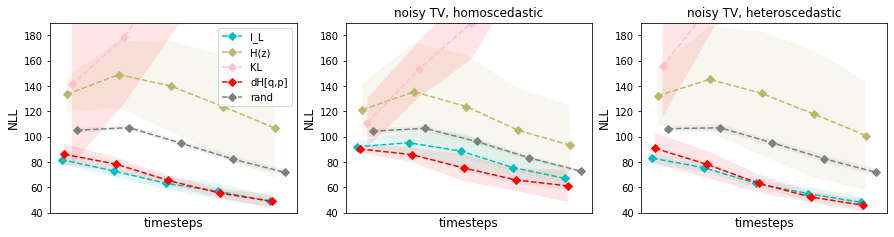

In [37]:
# plot quantitative results, baseline-corrected MSE

plt.figure(figsize=(15,3.5))
noisyTVList = [False,True,True]
homoscedList = [True,True,False]
allTitles = ['', 'noisy TV, homoscedastic', 'noisy TV, heteroscedastic']
for condition in range(3):
    addNoisyTV = noisyTVList[condition]
    homoscedastic = homoscedList[condition]
    
    for init in range(10):
        
        # the first is the main result, and the second is when we a random patch is used in the first step
        filename = 'as_noise_' + str(addNoisyTV)  + '_homosced_' + str(homoscedastic) + '_' + str(init)
#         filename = 'as_randomFirstStep_noise_' + str(addNoisyTV)  + '_homosced_' + str(homoscedastic) + '_' + str(init)

        with open(filename +'.pkl', 'rb') as infile:
            result = pickle.load(infile)

        allLosses_train, allLosses_valid, allNLL, allNLL_ent_z, \
                allNLL_ent_zgx, allNLL_rand, allNll_min, allIndices, allNLL_KL, \
                allNLL_dH, allIndices_KL,  allAcc, allAcc_ent_z, allAcc_ent_zgx, \
                allAcc_KL, allAcc_dH, allAcc_rand, allAcc_min = result
        
        # baseline correct by removing the NLL for best possible patch location
        allNLL = allNLL - allNll_min
        allNLL_ent_z = allNLL_ent_z - allNll_min
        allNLL_ent_zgx = allNLL_ent_zgx - allNll_min
        allNLL_rand = allNLL_rand - allNll_min
        allNLL_KL = allNLL_KL - allNll_min
        allNLL_dH = allNLL_dH - allNll_min
        
        if init==0:
            NLL = np.expand_dims(np.mean(allNLL,-1),1)
            NLLent_z = np.expand_dims(np.mean(allNLL_ent_z,-1),1)
            NLL_ent_zgx = np.expand_dims(np.mean(allNLL_ent_zgx,-1),1)
            NLLrand = np.expand_dims(np.mean(allNLL_rand,-1),1)
            NLL_KL = np.expand_dims(np.mean(allNLL_KL,-1),1)
            NLL_dH =  np.expand_dims(np.mean(allNLL_dH,-1),1)
        else:
            NLL = np.concatenate((NLL,np.expand_dims(np.mean(allNLL,-1),1)),axis=1)
            NLLent_z = np.concatenate((NLLent_z,np.expand_dims(np.mean(allNLL_ent_z,-1),1)),axis=1)
            NLL_ent_zgx = np.concatenate((NLL_ent_zgx,np.expand_dims(np.mean(allNLL_ent_zgx,-1),1)),axis=1)
            NLLrand = np.concatenate((NLLrand,np.expand_dims(np.mean(allNLL_rand,-1),1)),axis=1)
            NLL_KL = np.concatenate((NLL_KL,np.expand_dims(np.mean(allNLL_KL,-1),1)),axis=1)
            NLL_dH = np.concatenate((NLL_dH,np.expand_dims(np.mean(allNLL_dH,-1),1)),axis=1)

    allNLL_mean = np.mean(NLL,axis=1); allNLL_std = np.std(NLL,axis=1);
    allNLL_ent_z_mean = np.mean(NLLent_z,axis=1); allNLL_ent_z_std = np.std(NLLent_z,axis=1);
    allNLL_ent_zgx_mean = np.mean(NLL_ent_zgx,axis=1); allNLL_ent_zgx_std = np.std(NLL_ent_zgx,axis=1);
    allNLL_rand_mean = np.mean(NLLrand,axis=1); allNLL_rand_std = np.nanstd(NLLrand,axis=1);
    allNLL_KL_mean = np.nanmean(NLL_KL,axis=1); allNLL_KL_std = np.nanstd(NLL_KL,axis=1);
    allNLL_dH_mean = np.nanmean(NLL_dH,axis=1); allNLL_dH_std =np.nanstd(NLL_dH,axis=1)

    plt.subplot(1,3,condition+1)
    ax_I = plt.errorbar([1,3,5,7,9], allNLL_mean, color='c', ls='--', marker='D', elinewidth=.5, capsize=3, capthick=0.5,label = 'I_L');
    plt.fill_between([1,3,5,7,9], allNLL_mean-allNLL_std, allNLL_mean+allNLL_std,facecolor='c',alpha=0.1)

    ax_Hz = plt.errorbar([1.2,3.2,5.2,7.2,9.2], allNLL_ent_z_mean, color='darkkhaki', ls='--', marker='D', elinewidth=0.5, capsize=3, capthick=0.5, label = 'H(z)');
    plt.fill_between([1.2,3.2,5.2,7.2,9.2], allNLL_ent_z_mean-allNLL_ent_z_std, allNLL_ent_z_mean+allNLL_ent_z_std,facecolor='darkkhaki',alpha=0.1)

    ax_KL = plt.errorbar([1.4,3.4,5.4,7.4,9.4], allNLL_KL_mean, color='pink', ls='--', marker='D', elinewidth=0.5, capsize=3, capthick=0.5, label = 'KL');
    plt.fill_between([1.4,3.4,5.4,7.4,9.4], allNLL_KL_mean-allNLL_KL_std, allNLL_KL_mean+allNLL_KL_std,facecolor='red',alpha=0.1)
    
    ax_dH = plt.errorbar([1.1,3.1,5.1,7.1,9.1], allNLL_dH_mean, color='red', ls='--', marker='D', elinewidth=0.5, capsize=3, capthick=0.5, label = 'dH[q,p]');
    plt.fill_between([1.1,3.1,5.1,7.1,9.1], allNLL_dH_mean-allNLL_dH_std, allNLL_dH_mean+allNLL_dH_std,facecolor='red',alpha=0.1)

    ax_R = plt.errorbar([1.6,3.6,5.6,7.6,9.6], allNLL_rand_mean, color='gray', ls='--', marker='D', elinewidth=0.5, capsize=3, capthick=0.5, label = 'rand');
    plt.fill_between([1.6,3.6,5.6,7.6,9.6], allNLL_rand_mean-allNLL_rand_std, allNLL_rand_mean+allNLL_rand_std,facecolor='gray',alpha=0.1)

    plt.ylabel('NLL',fontsize=12);
    plt.xlabel('timesteps',fontsize=12);
    ax=plt.gca(); ax.set_xticks([]); 
    if condition==0:
        ax.legend(fontsize=10);  
    plt.ylim([40,190]);
    plt.title(allTitles[condition])
    
# plt.savefig('quant1.pdf', format='pdf')

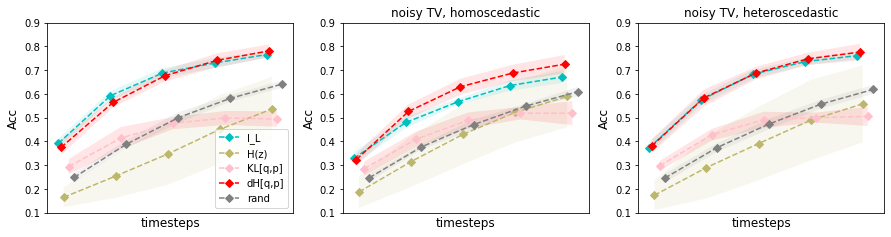

In [38]:
# plot quanititative results, classifier accuracy

plt.figure(figsize=(15,3.5))
noisyTVList = [False,True,True]
homoscedList = [True,True,False]
allTitles = ['', 'noisy TV, homoscedastic', 'noisy TV, heteroscedastic']
for condition in range(3):
    addNoisyTV = noisyTVList[condition]
    homoscedastic = homoscedList[condition]
    
    for init in range(10):

        filename = 'as_noise_' + str(addNoisyTV)  + '_homosced_' + str(homoscedastic) + '_' + str(init)
#         filename = 'as_randomFirstStep_noise_' + str(addNoisyTV)  + '_homosced_' + str(homoscedastic) + '_' + str(init)

        with open(filename +'.pkl', 'rb') as infile:
            result = pickle.load(infile)

        allLosses_train, allLosses_valid, allNLL, allNLL_ent_z, allNLL_ent_zgx, \
        allNLL_rand, allNll_min, allIndices, allNLL_KL, allNLL_dH, allIndices_KL, \
        allAcc, allAcc_ent_z, allAcc_ent_zgx, allAcc_KL, allAcc_dH, allAcc_rand, allAcc_min = result
        
        if init==0:
            Acc = np.expand_dims(allAcc,1)
            Accent_z = np.expand_dims(allAcc_ent_z,1)
            Acc_ent_zgx = np.expand_dims(allAcc_ent_zgx,1)
            Accrand = np.expand_dims(allAcc_rand,1)
            Acc_KL = np.expand_dims(allAcc_KL,1)
            Acc_dH =  np.expand_dims(allAcc_dH,1)
        else:
            Acc = np.concatenate((Acc, np.expand_dims(allAcc,1)),axis=1)
            Accent_z = np.concatenate((Accent_z,np.expand_dims(allAcc_ent_z,1)),axis=1)
            Acc_ent_zgx = np.concatenate((Acc_ent_zgx,np.expand_dims(allAcc_ent_zgx,1)),axis=1)
            Accrand = np.concatenate((Accrand,np.expand_dims(allAcc_rand,1)),axis=1)
            Acc_KL = np.concatenate((Acc_KL,np.expand_dims(allAcc_KL,1)),axis=1)
            Acc_dH = np.concatenate((Acc_dH,np.expand_dims(allAcc_dH,1)),axis=1)

    allAcc_mean = np.mean(Acc,axis=1); allAcc_std = np.std(Acc,axis=1)
    allAcc_ent_z_mean = np.mean(Accent_z,axis=1); allAcc_ent_z_std = np.std(Accent_z,axis=1)
    allAcc_ent_zgx_mean = np.mean(Acc_ent_zgx,axis=1); allAcc_ent_zgx_std = np.std(NLL_ent_zgx,axis=1)
    allAcc_rand_mean = np.mean(Accrand,axis=1); allAcc_rand_std = np.std(Accrand,axis=1)
    allAcc_KL_mean = np.nanmean(Acc_KL,axis=1); allAcc_KL_std =np.nanstd(Acc_KL,axis=1)
    allAcc_dH_mean = np.mean(Acc_dH,axis=1); allAcc_dH_std =np.std(Acc_dH,axis=1)

    plt.subplot(1,3,condition+1)
    ax_I = plt.errorbar([1,3,5,7,9], allAcc_mean, color='c', ls='--', marker='D', elinewidth=.5, capsize=3, capthick=0.5,label = 'I_L');
    plt.fill_between([1,3,5,7,9], allAcc_mean-allAcc_std, allAcc_mean+allAcc_std,facecolor='c',alpha=0.1)

    ax_Hz = plt.errorbar([1.2,3.2,5.2,7.2,9.2], allAcc_ent_z_mean, color='darkkhaki', ls='--', marker='D', elinewidth=0.5, capsize=3, capthick=0.5, label = 'H(z)');
    plt.fill_between([1.2,3.2,5.2,7.2,9.2], allAcc_ent_z_mean-allAcc_ent_z_std, allAcc_ent_z_mean+allAcc_ent_z_std,facecolor='darkkhaki',alpha=0.1)

    ax_KL = plt.errorbar([1.4,3.4,5.4,7.4,9.4], allAcc_KL_mean, color='pink', ls='--', marker='D', elinewidth=0.5, capsize=3, capthick=0.5, label = 'KL[q,p]');
    plt.fill_between([1.4,3.4,5.4,7.4,9.4], allAcc_KL_mean-allAcc_KL_std, allAcc_KL_mean+allAcc_KL_std,facecolor='red',alpha=0.1)
    
    ax_dH = plt.errorbar([1.1,3.1,5.1,7.1,9.1], allAcc_dH_mean, color='red', ls='--', marker='D', elinewidth=0.5, capsize=3, capthick=0.5, label = 'dH[q,p]');
    plt.fill_between([1.1,3.1,5.1,7.1,9.1], allAcc_dH_mean-allAcc_dH_std, allAcc_dH_mean+allAcc_dH_std,facecolor='red',alpha=0.1)

    ax_R = plt.errorbar([1.6,3.6,5.6,7.6,9.6], allAcc_rand_mean, color='gray', ls='--', marker='D', elinewidth=0.5, capsize=3, capthick=0.5, label = 'rand');
    plt.fill_between([1.6,3.6,5.6,7.6,9.6], allAcc_rand_mean-allAcc_rand_std, allAcc_rand_mean+allAcc_rand_std,facecolor='gray',alpha=0.1)

    plt.ylabel('Acc',fontsize=12);
    plt.xlabel('timesteps',fontsize=12);
    ax=plt.gca(); ax.set_xticks([]); 
    if condition==0:
        ax.legend(fontsize=10); 
    plt.ylim([.1,.9]);
    plt.title(allTitles[condition])
# plt.savefig('quant2.pdf', format='pdf')

# Qualitative results, Figure 5

In [92]:
# pretty colormap

from matplotlib.colors import ListedColormap
def get_cmap(code):
    N = 20
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(code[0]/256, 1, N)
    vals[:, 1] = np.linspace(code[1]/256, 1, N)
    vals[:, 2] = np.linspace(code[2]/256, 1, N)
    newcmp = ListedColormap(np.flipud(vals))
    return newcmp

In [99]:
# optimize I_L wrt patch location on a batch of test images, recording intermediate indices at every iteration

init = 1 # which model to pick
lr_action = .1
nIter = 100
    
# Set the model instance parameters
state_dim = 64   # of latent state z
num_hidden = 128 # of memory h
im_size = 28     # image width and height
wi = 2           # patch halfwidth
batch_size = 128 
input_dim = im_size*im_size
addNoisyTV = True

getMI_Laplace = get_patch_optimizer()

# prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
if addNoisyTV:
    X_train = add_noise(X_train,noiseWeight=10.)
    X_test = add_noise(X_test,noiseWeight=10.)
    
images = X_test[:batch_size]
labels = y_test[:batch_size]
    
IND_COND = []; INDcoll_COND = []; IMG_COND = []; MODEL_COND = [];

for condition in range(2):
    homoscedastic = not bool(condition)
    data = MNIST_to_RNN(images) # validation data
    # fetch a model
    model = VRNN(num_hidden,batch_size,input_dim,state_dim,homoscedastic)
    print(np.mean(model(data))) # init model weights
    model.load_weights('m_noise_' + str(addNoisyTV)  + '_homosced_' + str(homoscedastic) + '_' + str(init)) # load
    print(np.mean(model(data))) # show the loss again

    ## optimize indices
    nTimesteps = 5
    measure_flag = 'I(z;x)'
    allNLL = np.zeros(nTimesteps)
    optimizer_action = tf.keras.optimizers.Adam(learning_rate=lr_action)
    images_shaped = tf.reshape(images,(-1,im_size,im_size))
    
    # sample random indeces for all timesteps
    allIndices = tf.random.uniform((batch_size,nTimesteps,2), minval = wi, maxval=im_size-wi, dtype=tf.float32)
    allIndices = tf.Variable(allIndices) # Variables can be optimized
    INDcollector = np.zeros(((batch_size,nTimesteps,2) + (nIter,)))
    
    # initialize the RNN state at t0
    state = model.get_h0(batch_size) # predict h_0 from the first observation
    
    for tt in range(nTimesteps):
        # optimize info step
        for iter in range(nIter):
            INDcollector[:,tt,:,iter] = allIndices.numpy()[:,tt,:]
            # get grad dIG/da
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(allIndices)
                indeces = tf.squeeze(tf.slice(allIndices,[0,tt,0],[batch_size,1,2]))
                
                mean_p, var_p = model.cell.get_p(indeces,state)    
                entPrior, entLike, entPost, INFOgain = getMI_Laplace(mean_p,var_p,model) 
                loss_t = tf.reduce_mean(-INFOgain)
            # apply grad 
            grad = tape.gradient(loss_t,allIndices)
            optimizer_action.apply_gradients(zip([grad],[allIndices]))
        
        # generative process, get the patches of optimized indeces
        indeces_R = tf.cast(tf.round(allIndices[:,tt,:]),tf.int32)
        indeces_R = tf.clip_by_value(indeces_R, wi, im_size-wi)
        wi_map = tf.cast(tf.ones(batch_size,1)*wi,tf.int32)
        patches_shaped = tf.map_fn(get_patches,(images_shaped,indeces_R,wi_map), dtype= (tf.float32))
        patches = tf.reshape(patches_shaped,(-1,wi*2*wi*2))

        # process the patches and update the state
        indeces = tf.squeeze(tf.slice(allIndices,[0,tt,0],[batch_size,1,2]))
        data = tf.concat([images,indeces,patches],axis=1)
        _, state, _, _, _, _, _, _, _, _ = model.cell.step(data,state,training=False)

    IND_COND.append(allIndices)
    INDcoll_COND.append(INDcollector)
    IMG_COND.append(images)
    MODEL_COND.append(model)

3375.4507
1384.616
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tracing
5804.3994
1380.4254
tracing


In [100]:
# get I_L, dH measures for every possible patch location of a specific image

im = 3 # index of the test image to analyze and plot

images_PLOT = np.zeros((28,28,5,2)); # x * y * timestep * condition
entopy_PLOT = np.zeros((28,28,5,2));
infogn_PLOT = np.zeros((28,28,5,2));
nlogli_PLOT = np.zeros((28,28,5,2));
maskIG_PLOT = np.zeros((28,28,5,2));
recoIM_PLOT = np.zeros((28,28,5,2));
infogn_PLOT2 =  np.zeros((28,28,5,2));

for condition in range(2):
    homoscedastic = not bool(condition)

    allIndices = IND_COND[condition]
    INDcollector = INDcoll_COND[condition]
    images = IMG_COND[condition]
    model = MODEL_COND[condition]

    getMI_Laplace = get_patch_optimizer()

    testImage = np.reshape(images[im],(im_size,im_size))
    state = model.get_h0(1) # predict h_0 from the first observation

    # list all possible patch locations
    pcList = []
    for yy in range(im_size//wi-1):
        for xx in range(im_size//wi-1):
            pcList.append([wi*(yy+1),wi*(xx+1)])
            
    indeces_R = tf.constant(pcList)
    b_size = len(pcList)
    wi_map = tf.cast(tf.ones(b_size,1)*wi,tf.int32)
    # repeat the same test image acc to numPatches
    testImages = tf.tile(images[im:im+1],[b_size,1]) # 169,784
    testImages_shaped = tf.reshape(testImages,(-1,im_size,im_size))
    # extract the patches acocording to indices
    testPatches_shaped = tf.map_fn(get_patches,(testImages_shaped,indeces_R,wi_map), dtype= (tf.float32)) #169,4,4
    testPatches = tf.reshape(testPatches_shaped,(-1,wi*2*wi*2))
    testIndeces = tf.cast(indeces_R,tf.float32)
    testData = tf.concat([testImages,testIndeces,testPatches],axis=1)
    
    for ii in range(5):

        ## get the entropies and info gain for all possible gaze locations, to be used later
        entMask = np.zeros_like(testImage); infoMask = np.zeros_like(testImage); 
        varMask = np.zeros_like(testImage); NLLMask = np.zeros_like(testImage); allINFOgains = []
        infoMask2 = np.zeros_like(testImage); 
        
        # get the prior p(z) at the timestep ii
        mean_p_i, var_p_i = model.cell.get_p(testIndeces,[tf.repeat(state[0],b_size,axis=0)])
        # get the infomeasure at the corresponding prior
        entPrior, entLike, entPost, INFOgain = getMI_Laplace(mean_p_i,var_p_i,model)
        
        # the same but for dH
        # get q(z|x,a)
        h = tf.repeat(state[0],169,0) # state repeated for all locations
        a_ = model.cell.phi_a(testIndeces) # transformed action
        x_ = model.cell.phi_x(testPatches) # transformed observation
        z_hidden = model.cell.qz(model.cell.phi_e(tf.concat((x_,a_,h),axis=1))) # observation + prev.action + prev.state
        mean_q, logvar_q = tf.split(z_hidden, num_or_size_splits=2, axis=1) 
        var_q = tf.exp(logvar_q)

        # get info measures
        precisionPrior = tf.linalg.diag(1./var_p_i)
        entPrior = - tf.linalg.logdet(precisionPrior);
        entLike = entPrior
        precisionPost = tf.linalg.diag(1./var_q)
        entPost = - tf.linalg.logdet(precisionPost); 
        INFOgain2 = entPrior - entPost
        # end for dH
        
        # get the image reconstruction error at every timestep for every possible patch
        _, _, _, _, mean_q, _, _, _, _, _ = model.cell.step(testData,[tf.repeat(state[0],b_size,axis=0)],training=False)
        p_xgz_image = model.cell.decoder_image(mean_q) 
        nll = - p_xgz_image.log_prob(testImages)
        nll = tf.reduce_sum(nll,-1) # across pixels

        # fill the mask images according to entropies and infogains at every patch location
        for num,patc in enumerate(pcList):
            entMask[patc[0]-wi:patc[0]+wi,patc[1]-wi:patc[1]+wi] = np.squeeze(entPrior[num])*np.ones((wi*2,wi*2)) # wi is patch width
            infoMask[patc[0]-wi:patc[0]+wi,patc[1]-wi:patc[1]+wi] = np.squeeze(INFOgain[num])*np.ones((wi*2,wi*2)) # wi is patch width
            infoMask2[patc[0]-wi:patc[0]+wi,patc[1]-wi:patc[1]+wi] = np.squeeze(INFOgain2[num])*np.ones((wi*2,wi*2)) # wi is patch width
            NLLMask[patc[0]-wi:patc[0]+wi,patc[1]-wi:patc[1]+wi] = np.squeeze(nll[num])*np.ones((wi*2,wi*2)) 
            allINFOgains.append(INFOgain)

        # pick the optimized indices to overlay the optimized patch in the first row 
        indeces_R = tf.cast(tf.round(allIndices[im,ii,:]),tf.int32)
        indeces_R = tf.clip_by_value(indeces_R, wi, im_size-wi)
        pc = indeces_R
        patches_shaped = testImage[pc[0]-wi:pc[0]+wi,pc[1]-wi:pc[1]+wi]
        patchMask = np.zeros_like(testImage) 
        patchMask[pc[0]-wi:pc[0]+wi,pc[1]-wi:pc[1]+wi] = np.ones_like(patches_shaped) # wi is patch width

        # add the entire optimization trajectory
        for iter in range(nIter):
            indeces_R = np.round(INDcollector[im,ii,:,iter]).astype(np.int32)
            indeces_R = np.clip(indeces_R, wi, im_size-wi)
            pc = indeces_R
            patchMask[pc[0],pc[1]] =  1. #.5 + (1./nIter)*iter

        # use the optimized patch to get p(z,x) and to propagate to the next timestep
        images_in = images[im]
        indeces_in = tf.cast(pc,tf.float32)
        patches_in = tf.reshape(patches_shaped,(wi*2*wi*2,))
        data = tf.expand_dims(tf.cast(tf.concat([images_in,indeces_in,patches_in],axis=0),tf.float32),axis=0)
        loss, state, mean_p, var_p, mean_q, var_q, mean_xgz, var_xgz, mean_pat, var_pat = model.cell.step(data,state,training=False)
        
        images_PLOT[:,:,ii,condition] = testImage
        maskIG_PLOT[:,:,ii,condition] = patchMask
        recoIM_PLOT[:,:,ii,condition] = np.reshape(mean_xgz[0,:im_size*im_size],(im_size,im_size))
        entopy_PLOT[:,:,ii,condition] = entMask;
        infogn_PLOT[:,:,ii,condition] = infoMask;
        infogn_PLOT2[:,:,ii,condition]= infoMask2;
        nlogli_PLOT[:,:,ii,condition] = NLLMask;

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tracing
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on 

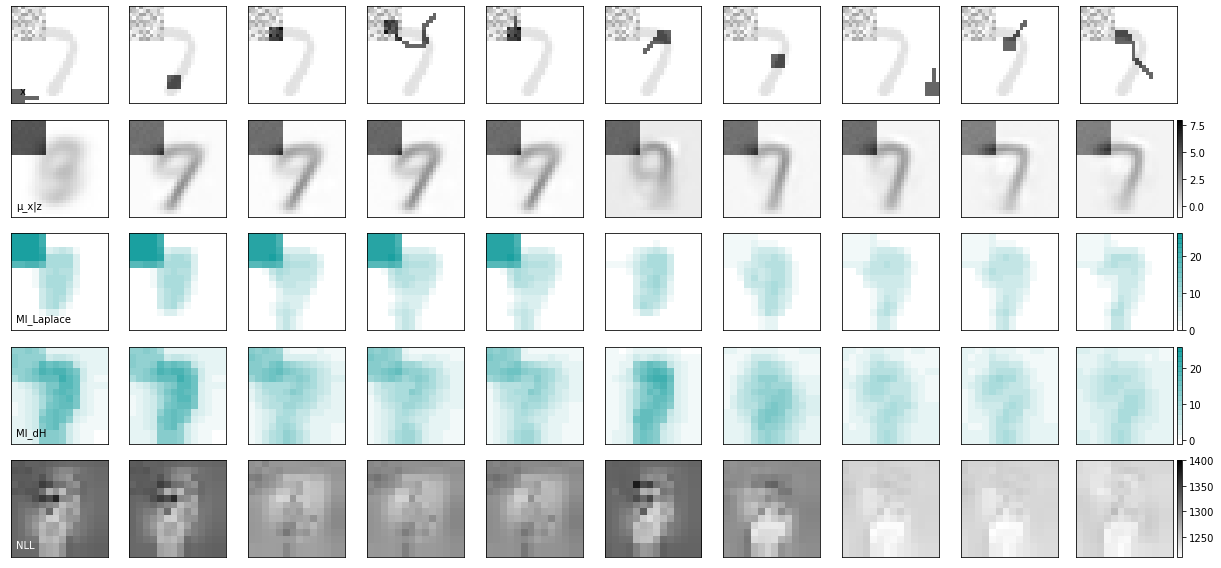

In [101]:
plt.figure(figsize=(17.1,8))
# plt.figure(figsize=(16,6))
for condition in range(2):       
    for ii in range(5):
        # show the actual image and optimizaed patch
        plt.subplot(5,10, ii + 1 + 5*condition)
        plt.imshow(images_PLOT[:,:,ii,condition],alpha = .9,cmap='gray_r'); 
        plt.imshow(maskIG_PLOT[:,:,ii,condition],alpha = .6,cmap='gray_r'); plt.xticks([]); plt.yticks([]); # to overlay the location of the patch
        if ii==0 and condition==0: plt.text(2,25,'x')

        # show the mean of p(x|z) i.e. the reconstructed image at the current timestep 
        plt.subplot(5,10,ii+11 + 5*condition)
        splt = plt.imshow(recoIM_PLOT[:,:,ii,condition],alpha = .8,cmap='gray_r'); plt.xticks([]); plt.yticks([]);
        if ii==4 and condition==1: plt.colorbar(splt,fraction=0.046, pad=0.04);
        if ii==0 and condition==0: plt.text(1,25,'μ_x|z')

        # show infogain mask
        plt.subplot(5,10,ii+21 + 5*condition)
        splt = plt.imshow(infogn_PLOT[:,:,ii,condition],alpha = .9, \
                    vmin=np.floor(np.min(infogn_PLOT[:,:,:,:])),vmax=np.ceil(np.max(infogn_PLOT[:,:,:,:])), \
                    cmap=get_cmap([1,150,150])); plt.xticks([]); plt.yticks([]); # to overlay the location of the patch
        if ii==4 and condition==1: plt.colorbar(splt,fraction=0.046, pad=0.04);
        if ii==0 and condition==0: plt.text(1,25,'MI_Laplace')

        # show infogain2 mask
        plt.subplot(5,10,ii+31 + 5*condition)
        splt = plt.imshow(infogn_PLOT2[:,:,ii,condition],alpha = .9, \
                    vmin=np.floor(np.min(infogn_PLOT2[:,:,:,:])),vmax=np.ceil(np.max(infogn_PLOT[:,:,:,:])), \
                    cmap=get_cmap([1,150,150])); plt.xticks([]); plt.yticks([]); # to overlay the location of the patch
        if ii==4 and condition==1: plt.colorbar(splt,fraction=0.046, pad=0.04);
        if ii==0 and condition==0: plt.text(1,25,'MI_dH')

        # show prediction error mask
        plt.subplot(5,10,ii+41 + 5*condition)
        splt = plt.imshow(nlogli_PLOT[:,:,ii,condition],alpha = .9, \
                          vmin=np.floor(np.min(nlogli_PLOT[:,:,:,:])),vmax=np.ceil(np.max(nlogli_PLOT[:,:,:,:])), \
                          cmap='gray_r'); plt.xticks([]); plt.yticks([]);
        if ii==4 and condition==1: plt.colorbar(splt,fraction=0.046, pad=0.04);
        if ii==0 and condition==0: plt.text(1,25,'NLL',color = 'white');
plt.tight_layout(h_pad=1)
# plt.savefig('qual.pdf', format='pdf')

## Piecewise linearity experiment, Appendix Figure 1

In [114]:
# encode only patches
@tf.function
def extract_patches(images):
    im_size = 28 
    wi = 2
    images_shaped = tf.reshape(images,(-1,im_size,im_size))
    batch_size = images.shape[0]
    wi_map = tf.cast(tf.ones(batch_size,1)*wi,tf.int32)
    indeces = tf.random.uniform((batch_size,2), minval = wi, maxval=im_size-wi,dtype=tf.int32)
    patches_shaped = tf.map_fn(get_patches,(images_shaped,indeces,wi_map), dtype= (tf.float32))
    patches = tf.reshape(patches_shaped,(-1,wi*2*wi*2))
    return patches

In [115]:
# Decoder defines the mapping p(x|z), but we also add the encoder that amortizes q(z|x),
class VAE(tf.keras.Model):
    def __init__(self,nX = 2, nZ = 1, linear = False, beta = 1., twolayers=True, activation='sofplus'):
        super(VAE, self).__init__()
        self.linear = linear
        self.neurons = 64
        self.beta = beta
        self.p_z = tfd.Normal(loc=tf.zeros(nZ), scale=tf.ones(nZ)) # N(0,1)
        
        net = [tf.keras.layers.InputLayer(input_shape = (nX,))]
        net.append(tf.keras.layers.Dense(self.neurons,'relu'))
        net.append(tf.keras.layers.Dense(self.neurons,'relu'))
        net.append(tf.keras.layers.Dense(nZ*2))

        self.encoder = tf.keras.Sequential(net)
        
        inputs = tf.keras.Input(shape=(nZ,))
        
        if twolayers:
            self.decoder1 = tf.keras.layers.Dense(self.neurons,activation)
            self.decoder2 = tf.keras.layers.Dense(self.neurons,activation)
            self.decoder3 = tf.keras.layers.Dense(nX)
            d = self.decoder1(inputs)
            d2 = self.decoder2(d)
            m = self.decoder3(d2) # predicting mean
        else:
            self.decoder1 = tf.keras.layers.Dense(self.neurons,activation)
            self.decoder3 = tf.keras.layers.Dense(nX)
            d = self.decoder1(inputs)
            m = self.decoder3(d) # predicting mean
            
        p_xgz = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale = tf.ones_like(t))) (m)

        self.decoder = tf.keras.Model(inputs=inputs, outputs=p_xgz)

    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def sample(self, mean, logvar):
        # eps = tf.random_normal(shape=mean.shape)
        eps =  self.p_z.sample()
        return eps * tf.sqrt(tf.exp(logvar)) + mean
      
    def decode(self, latent):
        x_dist = self.decoder(latent)
        x_ = x_dist.mean()
        x_var = x_dist.variance()
        return x_, x_var

    def get_analytical_posterior(self,x):
        C = self.decoder.weights[0].numpy().T # x ~ Cz + eps
        mu_z = tf.expand_dims(self.p_z.mean(),-1) # expanding dims for matmul
        Si_z = tf.diag(self.p_z.variance())
        p_xgz = self.decoder(tf.expand_dims(self.p_z.mean(),0))
        Si_xgz = tf.matrix_diag(tf.squeeze(p_xgz.variance(),axis=0))
        Si_z_x = tf.linalg.inv(tf.linalg.inv(Si_z) + tf.matmul(tf.transpose(C),tf.matmul(tf.linalg.inv(Si_xgz),C)))
        mu_z_x = tf.matmul(Si_z_x, tf.matmul(tf.transpose(C),tf.matmul(tf.linalg.inv(Si_xgz),x))
                                + tf.matmul(tf.linalg.inv(Si_z),mu_z))
        return mu_z_x, Si_z_x

    def __call__(self, x):
        mean, logvar = self.encode(x)
        latent = self.sample(mean, logvar)
        p_xgz = self.decoder(latent)
        x_ = p_xgz.mean()
        RECO = -p_xgz.log_prob(x)
        # RECO = tf.reduce_sum(RECO,(1,2,3)) # 4 are channels, only if convolutional
        RECO = tf.reduce_sum(RECO,-1) # across dimensions

        # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
        KL = - 0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=-1)
        loss = tf.reduce_mean(RECO + self.beta*KL, axis = -1) # across batch
        return loss, p_xgz

    def get_loss(self, data):
        return self.__call__(data)[0]

In [116]:
# Lets now test the model with both nZ and nX >1
wi = 2           # patch halfwidth
nZ = 2
linear = False

twolayers = True
activation = 'softplus'
onlyPatches = True

if onlyPatches:
    nX = wi*2*wi*2
else:
    nX = X_train.shape[1]

model = VAE(nX = nX, nZ = nZ, linear = linear, beta = 1., twolayers = twolayers,activation=activation) 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
out = model(tf.ones(shape=(128, nX)))[1] # we pass the model fake data just to initialize the weights

In [117]:
@tf.function
def train_step_MNIST(batch,model,optimizer):
    with tf.GradientTape() as tape:
        loss = model(batch)[0]
        loss = tf.reduce_mean(loss) # across timesteps and batch
    grads = tape.gradient(loss, model.trainable_variables)
#     grads_clipped, _ = tf.clip_by_global_norm(grads, 10.)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [120]:
# prepare the data
X = mnist.data.astype('float32')
# X /= 255.0
X = (X - np.mean(X))/np.std(X)
y = mnist.target.astype('int64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape)

(63000, 784)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


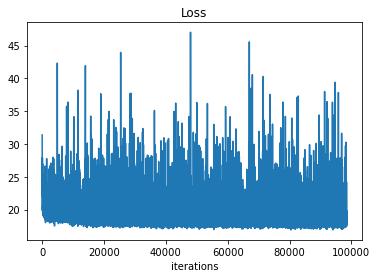

In [121]:
# Lets train the model, mostly to get the encoder doing its job

# by epochs
batch_size = 128
allLosses = []
allLosses_test = []
for epoch in range(200):
    print(epoch)
    indeces = np.arange(0,X_train.shape[0])
    np.random.shuffle(indeces)
    for batch in range(X_train.shape[0]//batch_size):
        input_data = X_train[indeces[batch*batch_size:(batch+1)*batch_size]]
        if onlyPatches:
            input_data = extract_patches(input_data)
        loss_batch = train_step_MNIST(input_data,model,optimizer)
        allLosses.append(loss_batch)
plt.plot(allLosses); plt.title('Loss'); plt.xlabel('iterations');
# loss_test, grads = model.get_grads(X_test) #

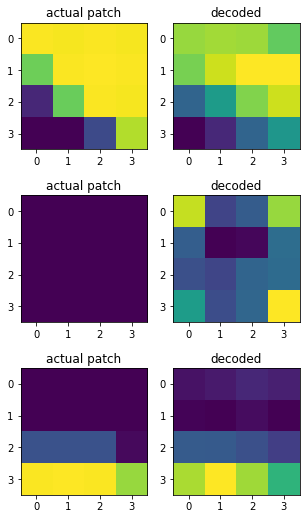

In [122]:
testPatches = extract_patches(X_test[:nPoints])
mean, logvar = model.encode(testPatches)
patches_hat = model.decode(mean)[0]
plt.figure(figsize=(5,9))
for ex in range(3):
    plt.subplot(3,2,(2*ex)+1)
    plt.imshow(np.reshape(testPatches[ex+5],(4,4)));  plt.title('actual patch');
    plt.subplot(3,2,(2*ex)+2)
    plt.imshow(np.reshape(patches_hat[ex+5],(4,4)));  plt.title('decoded');

In [144]:
X_test[:nPoints].shape

(256, 784)

In [146]:
patches[:nPoints].shape

(256, 196)

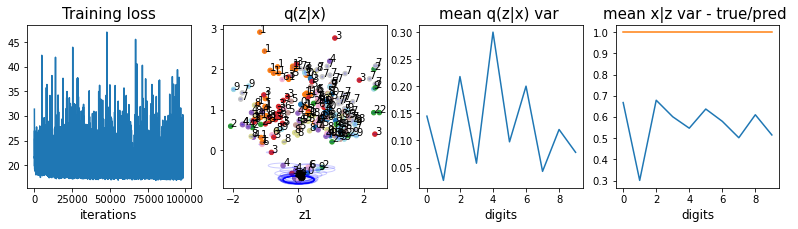

In [153]:
plt.figure(figsize=(17,3))# 1st subplot - means of the latent zplt.subplot2grid((1, 5), (0, 0))plt.plot(allLosses); plt.title('Training loss',fontsize=15); plt.xlabel('iterations',fontsize=12); # 2nd subplot - test q(z|x)plt.subplot2grid((1, 5), (0, 1))plt.scatter(mean[:,0],mean[:,1],c = labels, s=20, cmap = 'tab20');ells = [patches.Ellipse((mean[i,0], mean[i,1]), width = var[i,0], height = var[i,1], color='b', fill=False) for i in range(mean.shape[0])]ax = plt.gca()for e in ells:    ax.add_artist(e)    e.set_alpha(0.2)plt.xlabel('z1',fontsize=12); plt.title('mu of q(z|x)',fontsize=15);ax = plt.gca()for i, txt in enumerate(labels):    ax.annotate(txt, (mean[i, 0], mean[i, 1])) plt.subplot2grid((1, 5), (0, 2));# 3rd subplot - average variance of p(x|z) for different digitsplt.plot(np.arange(10),allVar);plt.plot(np.arange(10),allVar_pred);plt.title('mean x|z var - true/pred ',fontsize=15); plt.xlabel('digits',fontsize=12);  # 4th subplot - reconstructed zeroallVar = np.zeros(10)allVar_pred = np.zeros(10)for digit in range(10):    allVar[digit] = np.mean(np.std(X_train[y_train==digit],axis=0)**2);      p_xgz = model.decoder(model.encode(X_test[y_test==digit])[0])    allVar_pred[digit] = np.mean(p_xgz.variance())plt.subplot2grid((1, 5), (0, 3));index = 5p_xgz = model.decoder(model.encode(X_test[index:index+1])[0])plt.imshow(np.reshape(np.squeeze(p_xgz.mean()),(28,28))); plt.title('reconstructed 0 ',fontsize=12); # 5th subplot - prospective infogainmean, logvar = model.encode(X_test[:80])var = tf.exp(logvar).numpy()mean = mean.numpy()labels = y_test[:80]plt.subplot2grid((1, 5), (0, 4));plt.plot(np.squeeze(p_xgz.variance())); plt.title('x|z var of 0 = ' + str(np.mean(np.squeeze(p_xgz.variance()))),fontsize=12);plt.xlabel('dimensions of x',fontsize=12); 
# 1st subplot - means of the latent z
plt.subplot2grid((1, 5), (0, 0))
plt.plot(allLosses); plt.title('Training loss',fontsize=15); plt.xlabel('iterations',fontsize=12);
# plt.plot(allLosses_test); 

# 2nd subplot - test q(z|x)

X_test_reshaped = np.reshape(X_test,(-1,28,28))

pc = [10,15] # patchCenter

wi = 2
patches_reshaped = X_test_reshaped[:,pc[0]-wi:pc[0]+wi,pc[1]-wi:pc[1]+wi]
patches = np.reshape(patches_reshaped,(-1,wi*2*wi*2))

nPoints = 256
# mean, logvar = model.encode(X_test[:nPoints])
mean, logvar = model.encode(patches[:nPoints])
var = tf.exp(logvar).numpy()
mean = mean.numpy()
labels = y_test[:nPoints]
plt.subplot2grid((1, 5), (0, 1))
plt.scatter(mean[:,0],mean[:,1],c = labels, s=20, cmap = 'tab20');
ells = [pat.Ellipse((mean[i,0], mean[i,1]), width = var[i,0], height = var[i,1], color='b', fill=False) for i in range(mean.shape[0])]
ax = plt.gca()
for e in ells:
    ax.add_artist(e)
    e.set_alpha(0.2)
plt.xlabel('z1',fontsize=12); plt.title('q(z|x)',fontsize=15);
ax = plt.gca()
for i, txt in enumerate(labels):
    ax.annotate(txt, (mean[i, 0], mean[i, 1]))

# 3rd subplot - average var of q(z|x) for different digits
plt.subplot2grid((1, 5), (0, 2));
allVars = np.zeros(10)
for digit in range(10):
#     q_z_logvar = model.encode(X_test[y_test==digit])[1]
    q_z_logvar = model.encode(patches[y_test==digit])[1]
    q_z_var = tf.exp(q_z_logvar)
    allVars[digit] = np.mean(q_z_var)
plt.plot(np.arange(10),allVars)
plt.title('mean q(z|x) var ',fontsize=15); 
plt.xlabel('digits',fontsize=12); 

# 4th subplot - average variance of p(x|z) for different digits
plt.subplot2grid((1, 5), (0, 3));
allVar = np.zeros(10)
allVar_pred = np.zeros(10)
for digit in range(10):
    allVar[digit] = np.mean(np.std(X_train[y_train==digit],axis=0)**2); 
#     p_xgz = model.decoder(model.encode(X_test[y_test==digit])[0])
    p_xgz = model.decoder(model.encode(patches[y_test==digit])[0])
    allVar_pred[digit] = np.mean(p_xgz.variance())

plt.plot(np.arange(10),allVar);
plt.plot(np.arange(10),allVar_pred);
plt.title('mean x|z var - true/pred ',fontsize=15); 
plt.xlabel('digits',fontsize=12); 

if not onlyPatches:
    # 5th subplot - reconstructed 9
    plt.subplot2grid((1, 5), (0, 4));
    index = 11
    p_xgz = model.decoder(model.encode(X_test[index:index+1])[0])
    mu_xgz = p_xgz.mean()
    mu_xgz_im = mu_xgz[:,:28*28]
    plt.imshow(np.reshape(np.squeeze(mu_xgz_im),(28,28))); plt.title('reconstructed "9" ',fontsize=12);

In [154]:
# measuring linearity based on assigning unique codes

In [155]:
# if encoding only patches
nPoints = 512
if onlyPatches:
    mean, logvar = model.encode(extract_patches(X_test[:nPoints]))
else:
    mean, logvar = model.encode(X_test[:nPoints])
var = tf.exp(logvar).numpy()
mean = mean.numpy()
labels = y_test[:nPoints]

rangeX = [-4,4]
rangeY = [-4,4]
N = 317
X = np.linspace(rangeX[0], rangeX[1], N) # the range matters
Y = np.linspace(rangeY[1], rangeY[0], N)
XX, YY = np.meshgrid(X, Y) # make a grid
# Pack X and Y into a single 3-dimensional array
pos = np.empty(XX.shape + (2,))
pos[:, :, 0] = XX
pos[:, :, 1] = YY
z_grid = tf.reshape(pos,[-1,2])
z_grid.shape

TensorShape([100489, 2])

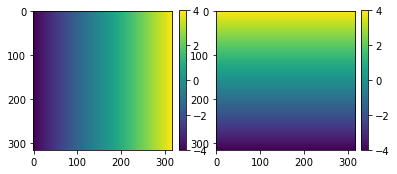

In [156]:
plt.subplot(1,2,1); im = plt.imshow(XX); plt.colorbar(im,fraction=0.046, pad=0.04);
plt.subplot(1,2,2); im = plt.imshow(YY); plt.colorbar(im,fraction=0.046, pad=0.04);

In [157]:
if twolayers:
    d1 = model.decoder1(tf.cast(z_grid,tf.float32))
    d2 = model.decoder2(d1)
    neurons = tf.concat([d1,d2],axis=-1)
else:
    d1 = model.decoder1(tf.cast(z_grid,tf.float32))
    neurons = d1
    
if activation=='softplus':
    codes = tf.cast(neurons>0.6931,tf.int32).numpy()
else:
    codes = tf.cast(neurons>0.,tf.int32).numpy()

uniqueCodes, indeces, counts = np.unique(codes, axis=0, return_inverse = True, return_counts = True)
sortedCountsInd = np.argsort(-counts)
nKeep = uniqueCodes.shape[0]

print(codes.shape)
print(uniqueCodes.shape)
print(indeces.shape)
print(np.max(indeces))

(100489, 128)
(2228, 128)
(100489,)
2227


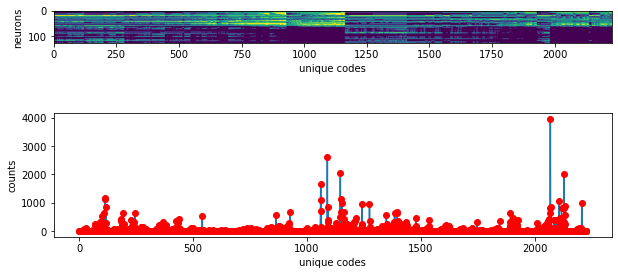

In [158]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.ylabel('neurons');
plt.xlabel('unique codes');
plt.imshow(uniqueCodes.T); plt.xlim(0,uniqueCodes.T.shape[1]);
plt.subplot(2,1,2)
plt.plot(counts);
plt.plot(sortedCountsInd[:nKeep],counts[sortedCountsInd[:nKeep]],'or');
plt.ylabel('counts');
plt.xlabel('unique codes');

In [159]:
# delete the ones that are not kept
indeces[np.nonzero(np.in1d(indeces,sortedCountsInd[nKeep:]))[0]]  = 0

In [160]:
# relabel unique indeces
unique2, indeces2, counts2 = np.unique(indeces, axis=0, return_inverse = True, return_counts = True)
for ii in range(unique2.shape[0]):
    indeces[indeces==unique2[ii]] = ii
print(unique2.shape[0])

2228


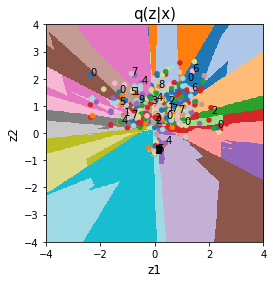

In [161]:
cmap20 = plt.get_cmap('PiYG', 130)    # 11 discrete colors
plt.imshow(indeces.reshape((N,N)),extent=[-4,4,-4,4],cmap = 'tab20', zorder=1,interpolation = 'None');
plt.scatter(mean[:,0],mean[:,1],c = labels, s=20, cmap = 'tab20', zorder=2); plt.xlim(-4,4); plt.ylim(-4,4)
ells = [pat.Ellipse((mean[i,0], mean[i,1]), width = var[i,0], height = var[i,1], color='b', fill=False) for i in range(mean.shape[0])]
ax = plt.gca()
for e in ells:
    ax.add_artist(e)
    e.set_alpha(0.2)
plt.xlabel('z1',fontsize=12); plt.ylabel('z2',fontsize=12); plt.title('q(z|x)',fontsize=15);
ax = plt.gca()
for i, txt in enumerate(labels):
    if i%10==0:
        ax.annotate(txt, (mean[i, 0], mean[i, 1]))

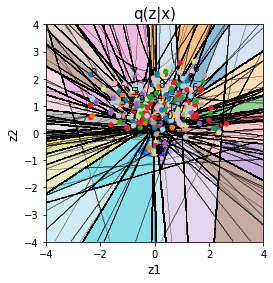

In [162]:
# plt.contour(indeces.reshape((N,N)),extent=[-4,4,-4,4],levels = np.arange(unique2.shape[0]),colors = 'k',linewidths=1.5,alpha=.1)
cmap20 = plt.get_cmap('tab20', 100)    # 11 discrete colors
plt.imshow(indeces.reshape((N,N)),extent=[-4,4,-4,4], cmap = cmap20, zorder=1,interpolation = 'None',alpha=.5);
plt.contour(indeces.reshape((N,N)),extent=[-4,4,-4,4],levels = np.arange(unique2.shape[0]),colors = 'k',origin='image',linewidths=.3,zorder=2)
plt.scatter(mean[:,0],mean[:,1],c = labels, s=20, cmap = 'tab20', zorder=3);  plt.xlim(-4,4); plt.ylim(-4,4)
ells = [pat.Ellipse((mean[i,0], mean[i,1]), width = var[i,0], height = var[i,1], color='b', fill=False) for i in range(mean.shape[0])]
ax = plt.gca()
for e in ells:
    ax.add_artist(e)
    e.set_alpha(0.2)
plt.xlabel('z1',fontsize=12); plt.ylabel('z2',fontsize=12); plt.title('q(z|x)',fontsize=15);
ax = plt.gca()
for i, txt in enumerate(labels):
    if i%10==0:
        ax.annotate(txt, (mean[i, 0], mean[i, 1]))

In [163]:
# lineary measure based on a kernel

In [164]:
# if encoding only patches
nPoints = 512
if onlyPatches:
    mean, logvar = model.encode(extract_patches(X_test[:nPoints]))
else:
    mean, logvar = model.encode(X_test[:nPoints])
var = tf.exp(logvar).numpy()
mean = mean.numpy()
labels = y_test[:nPoints]

rangeX = [-4,4]
rangeY = [-4,4]
N = 317
X = np.linspace(rangeX[0], rangeX[1], N) # the range matters
Y = np.linspace(rangeY[1], rangeY[0], N)
XX, YY = np.meshgrid(X, Y) #!!!!
# Pack X and Y into a single 3-dimensional array
pos = np.empty(XX.shape + (2,))
pos[:, :, 0] = XX
pos[:, :, 1] = YY
z_grid = tf.reshape(pos,[-1,2])
z_grid.shape

TensorShape([100489, 2])

In [165]:
if twolayers:
    d1 = model.decoder1(tf.cast(z_grid,tf.float32))
    d2 = model.decoder2(d1)
    Xhat = model.decoder3(d2).numpy()
else:
    d1 = model.decoder1(tf.cast(z_grid,tf.float32))
    Xhat = model.decoder3(d1).numpy()
Xhat = Xhat.reshape((N,N,-1))
Xhat.shape

(317, 317, 16)

In [166]:
kernel = np.array([[1,1,1],[1,-8,1],[1,1,1]])
kernel

array([[ 1,  1,  1],
       [ 1, -8,  1],
       [ 1,  1,  1]])

In [167]:
if onlyPatches:
    kernelRep = np.repeat(np.expand_dims(kernel,-1),16,-1) # if patches
else:
    kernelRep = np.repeat(np.expand_dims(kernel,-1),28*28,-1) # if images
print(kernelRep.shape)

(3, 3, 16)


In [168]:
layer = tf.keras.layers.Conv2D(1,(3,3),use_bias=False,padding='valid')
temp = np.squeeze(layer(np.expand_dims(Xhat,0)))
layer.set_weights([np.expand_dims(kernelRep,-1)])

convolved = np.squeeze(layer(np.expand_dims(Xhat,0)))
convolved = np.pad(convolved, [(1, 1), (1, 1)], mode='constant')

In [169]:
layer = tf.keras.layers.Conv2D(1,(3,3),use_bias=False,padding='valid')
temp = np.squeeze(layer(np.expand_dims(Xhat,0)))
layer.set_weights([np.expand_dims(kernelRep,-1)])
deltaList = [0.025, .1]
allLin = []
for dd in range(len(deltaList)):
    delta = deltaList[dd]
    linearity = [];
    for ii in range(mean.shape[0]):
        X = np.linspace(mean[ii,0] - delta, mean[ii,0] + delta, 3) # across rows
        Y = np.linspace(mean[ii,1] + delta, mean[ii,1] - delta, 3) # across columns
        XX, YY = np.meshgrid(X, Y)

        # Pack X and Y into a single 3-dimensional array
        pos = np.empty(XX.shape + (2,))
        pos[:, :, 0] = XX
        pos[:, :, 1] = YY
        z_grid = tf.reshape(pos,[-1,2])
        if twolayers:
            d1 = model.decoder1(tf.cast(z_grid,tf.float32))
            d2 = model.decoder2(d1)
            Xhat = model.decoder3(d2).numpy()
        else:
            d1 = model.decoder1(tf.cast(z_grid,tf.float32))
            Xhat = model.decoder3(d1).numpy()
        
        Xhat = Xhat.reshape((3,3,-1))
        linearity.append(np.squeeze(layer(np.expand_dims(Xhat,0))))
    allLin.append(linearity)

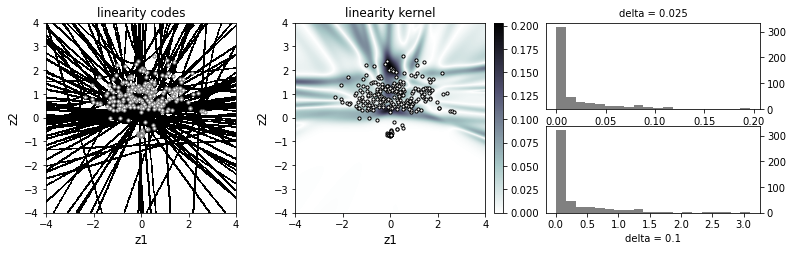

In [170]:
fig = plt.figure(figsize=(13,3.5))

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
cmap20 = plt.get_cmap('tab20', 100)    # 11 discrete colors
# plt.imshow(indeces.reshape((N,N)),extent=[-4,4,-4,4], cmap = cmap20, zorder=1,interpolation = 'None',alpha=.5);
plt.contour(indeces.reshape((N,N)),extent=[-4,4,-4,4],levels = np.arange(unique2.shape[0]),colors = 'k',origin='image',antialiased=False,linewidths=.3)
plt.scatter(mean[:,0],mean[:,1], facecolors='w', edgecolors='gray' ,s=10, cmap = 'tab20', zorder=3);  plt.xlim(-4,4); plt.ylim(-4,4)
# plt.scatter(mean[:,0],mean[:,1],c = labels, s=20, cmap = 'tab20', zorder=3);  plt.xlim(-4,4); plt.ylim(-4,4)
plt.xlabel('z1',fontsize=12); plt.ylabel('z2',fontsize=12);
plt.title('linearity codes')
asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
ax1.set_aspect(asp)

# convolved[np.abs(convolved)>1.5] = 1.5
ax2 = plt.subplot2grid((2, 3), (0, 1), rowspan=2)
im = plt.imshow(np.abs(convolved),extent=[-4,4,-4,4],cmap='bone_r'); plt.colorbar(im,fraction=0.046, pad=0.04);
if onlyPatches:
    plt.scatter(mean[:,0],mean[:,1], facecolors='w', edgecolors='k' ,s=10, cmap = 'tab20', zorder=3);  plt.xlim(-4,4); plt.ylim(-4,4)
else:
    plt.scatter(mean[:,0],mean[:,1],c = labels, s=10, cmap = 'tab20', zorder=3);  plt.xlim(-4,4); plt.ylim(-4,4)
    ax = plt.gca()
    for i, txt in enumerate(labels):
        if i%10==0:
            ax.annotate(txt, (mean[i, 0], mean[i, 1]))
plt.xlabel('z1',fontsize=12); plt.ylabel('z2',fontsize=12);
plt.title('linearity kernel')      
asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

ax3 = plt.subplot2grid((2, 3), (0, 2));
plt.hist(np.abs(allLin[0]),color='gray', bins=20);
plt.title('delta = ' + str(deltaList[0]), fontsize=10);
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

ax4 = plt.subplot2grid((2, 3), (1, 2));
plt.hist(np.abs(allLin[1]),color='gray', bins=20);
plt.xlabel('delta = ' + str(deltaList[1]));
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
# plt.savefig('softplus_digits_2_64_patches.pdf', format='pdf')